# Initial Exploration and baseline calculation (not cleaned up due to time constraint) 

## Intro
Your task is to build and explain a machine learning model that predicts whether a given domestic flight in the USA will be at least 15 minutes late.

This exercise is chosen because predicting service risk is one project you may
undertake at HASH.

We are looking to evaluate your **ability to reason about data, choose and explain an appropriate modelling approach, and produce well-documented and organised code**.

## Data

We have provided you with two datasets. You may use either or both as you see fit.
1. January 2025
2. February 2025

Each row represents a flight. The columns are as follows:

- DAY_OF_WEEK: Numbers representing Monday, Tuesday, etc. (sunday = 1 or monday = 1)
- FL_DATE: The date the flight was scheduled to leave.
- OP_CARRIER: The two-letter carrier code (e.g. AA = American Airlines).
- TAIL_NUM: The aircraft tail number (unique identifier for a specific plane).
- OP_CARRIER_FL_NUM: The flight number.
- ORIGIN: The origin city.
- ORIGIN_STATE_ABR: The origin’s two-letter US state abbreviation.
- DEST: The destination city.
- DEST_STATE_ABR: The destination’s two-letter US state abbreviation.
- CRS_DEP_TIME: The scheduled departure time.
- DEP_DELAY: The departure delay in minutes (negative = early).
- DEP_DEL15: Whether the departure was delayed by at least 15 minutes.
- CRS_ARR_TIME: The scheduled arrival time.
- ARR_DELAY: The arrival delay in minutes (negative = early).
- ARR_DEL15: Whether the arrival was delayed by at least 15 minutes.
- CANCELLED: Whether the flight was cancelled.
- DIVERTED: Whether flight was diverted.
- DISTANCE: The flight distance in miles.

## Objective

Use the provided dataset to predict ARR_DEL15.

You are free to design your own approach, to include for example:

*   Exploratory data analysis.
*   Feature engineering.
*   Choosing a suitable modeling method.
*   Evaluate model performance using appropriate metrics.


## Deliverables

Please submit any code used either as a notebook accessible online or a link to a GitHub or GitLab repository, and include comments and documentation.

We would like you to:
1. Report and ideally visualise key results, including which features most
influence delay risk.
2. Explain your choice of modelling approach, including comparisons with
alternative methods.
3. Mention potential limitations, biases, and improvements.

## Time expectation

We expect this exercise to take around 4–6 hours of focused work.

Please bias your time towards reasoning and explanation over model performance.

We are mainly looking to assess your ability to choose and explain appropriate tools, and to describe what further work would improve the approach and alternative strategies you might explore, rather than exhaustive experimentation.

## Initial Thoughts:
- limited amount of tabular data -> LightGBM or XGBoost would perform well
- classification problem
- larger delay might indicate impact of features
- seasonality cannot be detected due to january/february
- additional data could be beneficial
  - weather origin and and DEST
  - holidays / vacation times
  
- by using a treebased model we can determine feature importance
- dataset could consist of 90% January as training set and 10% January and Complete february as test set




In [1]:
!pip install Path

In [3]:
from pathlib import Path
# basePath = "/content/flight-data/"
basePath = Path("/content/drive/MyDrive/01-hash")

# Quick Baseline

In [6]:
import pandas as pd

df_jan = pd.read_csv( basePath / "flights_jan_2025.csv")
df_feb = pd.read_csv( basePath / "flights_feb_2025.csv")
df = pd.concat([df_jan, df_feb], ignore_index=True)
display(df_jan.head())


,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,1/6/2025 12:00:00 AM,AA,N102NN,16,SFO,CA,JFK,NY,1321,-5.0,0.0,2159,-6.0,0.0,0.0,0.0,2586.0
1,1,1/6/2025 12:00:00 AM,AA,N102NN,179,JFK,NY,SFO,CA,829,-5.0,0.0,1222,-40.0,0.0,0.0,0.0,2586.0
2,1,1/6/2025 12:00:00 AM,AA,N102UW,2056,CLT,NC,LGA,NY,1839,5.0,0.0,2030,13.0,0.0,0.0,0.0,544.0
3,1,1/6/2025 12:00:00 AM,AA,N102UW,2863,AUS,TX,CLT,NC,1356,3.0,0.0,1730,-13.0,0.0,0.0,0.0,1032.0
4,1,1/6/2025 12:00:00 AM,AA,N102UW,2999,CLT,NC,AUS,TX,1100,-1.0,0.0,1311,-6.0,0.0,0.0,0.0,1032.0


In [7]:
df.head()
df.info()
df['ARR_DEL15'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044631 entries, 0 to 1044630
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   DAY_OF_WEEK        1044631 non-null  int64  
 1   FL_DATE            1044631 non-null  object 
 2   OP_CARRIER         1044631 non-null  object 
 3   TAIL_NUM           1041297 non-null  object 
 4   OP_CARRIER_FL_NUM  1044631 non-null  int64  
 5   ORIGIN             1044631 non-null  object 
 6   ORIGIN_STATE_ABR   1044631 non-null  object 
 7   DEST               1044631 non-null  object 
 8   DEST_STATE_ABR     1044631 non-null  object 
 9   CRS_DEP_TIME       1044631 non-null  int64  
 10  DEP_DELAY          1021569 non-null  float64
 11  DEP_DEL15          1021569 non-null  float64
 12  CRS_ARR_TIME       1044631 non-null  int64  
 13  ARR_DELAY          1018745 non-null  float64
 14  ARR_DEL15          1018745 non-null  float64
 15  CANCELLED          1044631 non-n

,proportion
ARR_DEL15,
0.0,0.802471
1.0,0.197529


In [9]:
from sklearn.preprocessing import LabelEncoder

# Drop rows where the target variable is missing.
df = df.dropna(subset=["ARR_DEL15"])

# Define the target variable.
y = df["ARR_DEL15"]

# Define the features (X) by dropping irrelevant or leakage-inducing columns:
# - ARR_DEL15: This is the target variable. Including it would be data leakage.
# - FL_DATE: The full date string is dropped to avoid high cardinality. Relevant time-based features (like day of week) are kept or can be engineered.
# - DEP_DELAY and ARR_DELAY: These are the actual delay times. Including them would be data leakage as they are direct indicators of ARR_DEL15 and would likely not be available at the time of prediction.
X = df.drop(["ARR_DEL15", "FL_DATE", "DEP_DELAY", "ARR_DELAY"], axis=1)

# Encode categorical features using Label Encoding.
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

callbacks = [lgb.early_stopping(stopping_rounds=20)]
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.900527


In [14]:
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC:", roc_auc_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred_bin))
print("F1:", f1_score(y_val, y_pred_bin))

AUC: 0.9005266166922592
Accuracy: 0.9107038562152452
F1: 0.7687007373506229


AUC: 0.9005266166922592
Accuracy: 0.9107038562152452
F1: 0.7687007373506229


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

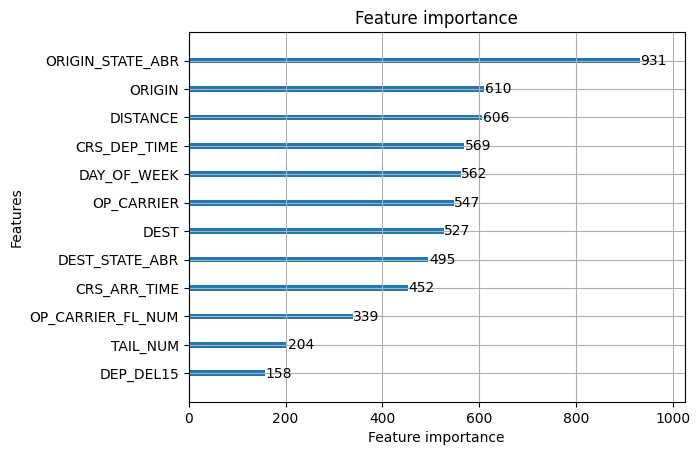

In [15]:
lgb.plot_importance(model, max_num_features=15)

# Exploratory Data Analysis



In [21]:

# Load both months
df_jan = pd.read_csv( basePath / "flights_jan_2025.csv")
df_feb = pd.read_csv( basePath / "flights_feb_2025.csv")
df = pd.concat([df_jan, df_feb], ignore_index=True)
df.head()


,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,1/6/2025 12:00:00 AM,AA,N102NN,16,SFO,CA,JFK,NY,1321,-5.0,0.0,2159,-6.0,0.0,0.0,0.0,2586.0
1,1,1/6/2025 12:00:00 AM,AA,N102NN,179,JFK,NY,SFO,CA,829,-5.0,0.0,1222,-40.0,0.0,0.0,0.0,2586.0
2,1,1/6/2025 12:00:00 AM,AA,N102UW,2056,CLT,NC,LGA,NY,1839,5.0,0.0,2030,13.0,0.0,0.0,0.0,544.0
3,1,1/6/2025 12:00:00 AM,AA,N102UW,2863,AUS,TX,CLT,NC,1356,3.0,0.0,1730,-13.0,0.0,0.0,0.0,1032.0
4,1,1/6/2025 12:00:00 AM,AA,N102UW,2999,CLT,NC,AUS,TX,1100,-1.0,0.0,1311,-6.0,0.0,0.0,0.0,1032.0


In [22]:
# Basic inspection
print(df.shape)
print(df.info())
print(df.describe())
print(df['ARR_DEL15'].value_counts(normalize=True))

(1044631, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044631 entries, 0 to 1044630
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   DAY_OF_WEEK        1044631 non-null  int64  
 1   FL_DATE            1044631 non-null  object 
 2   OP_CARRIER         1044631 non-null  object 
 3   TAIL_NUM           1041297 non-null  object 
 4   OP_CARRIER_FL_NUM  1044631 non-null  int64  
 5   ORIGIN             1044631 non-null  object 
 6   ORIGIN_STATE_ABR   1044631 non-null  object 
 7   DEST               1044631 non-null  object 
 8   DEST_STATE_ABR     1044631 non-null  object 
 9   CRS_DEP_TIME       1044631 non-null  int64  
 10  DEP_DELAY          1021569 non-null  float64
 11  DEP_DEL15          1021569 non-null  float64
 12  CRS_ARR_TIME       1044631 non-null  int64  
 13  ARR_DELAY          1018745 non-null  float64
 14  ARR_DEL15          1018745 non-null  float64
 15  CANCELLED         

In [27]:
# percentage of missing values per column
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

ARR_DELAY    0.024780
ARR_DEL15    0.024780
DEP_DELAY    0.022077
DEP_DEL15    0.022077
TAIL_NUM     0.003192
dtype: float64


*   Flights may have missing delays if canceled or diverted.

*   Removing or flagging canceled/diverted flights for the model.

there are canceled flights



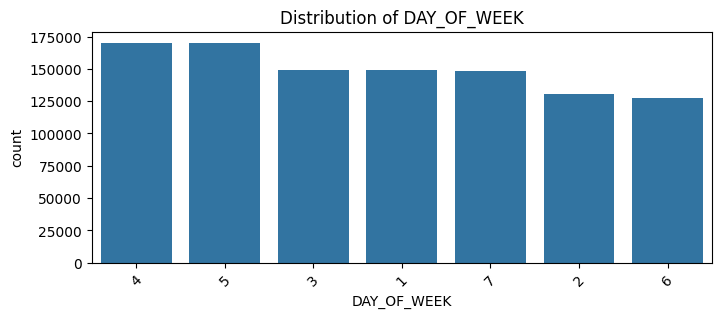

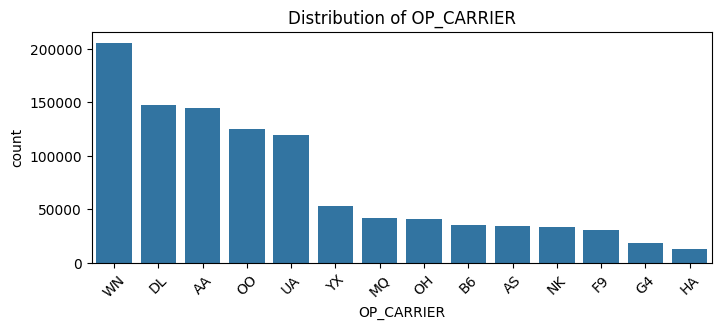

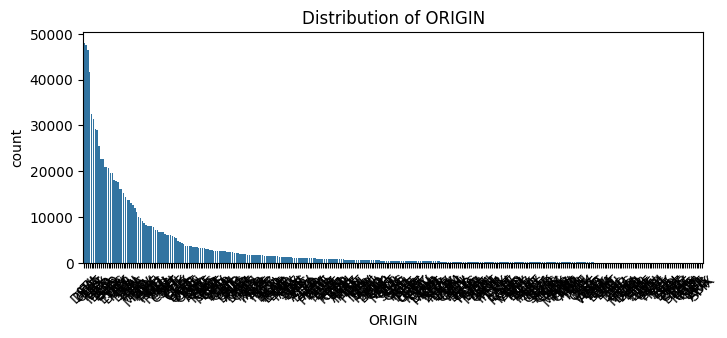

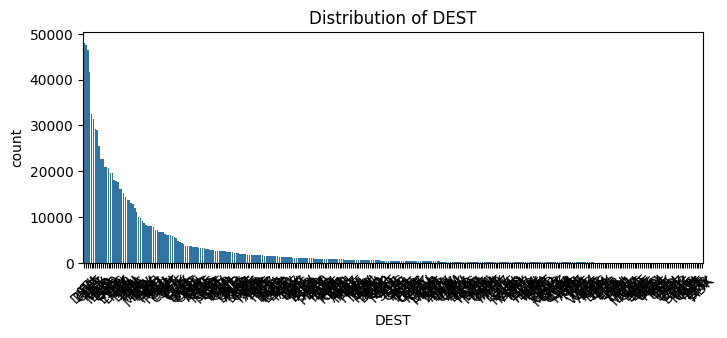

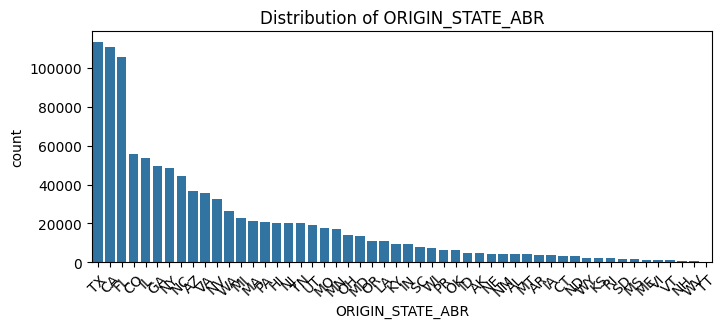

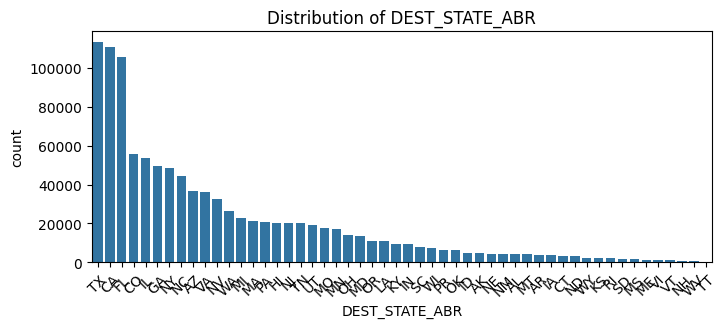

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR']

for col in categorical_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()




*   high-cardinality variables like airports or tail numbers
*   improve visualisation? take top 30 airports for instance

TODO: Busiest U.S. airports by domestic flight volume

Days with the most flights



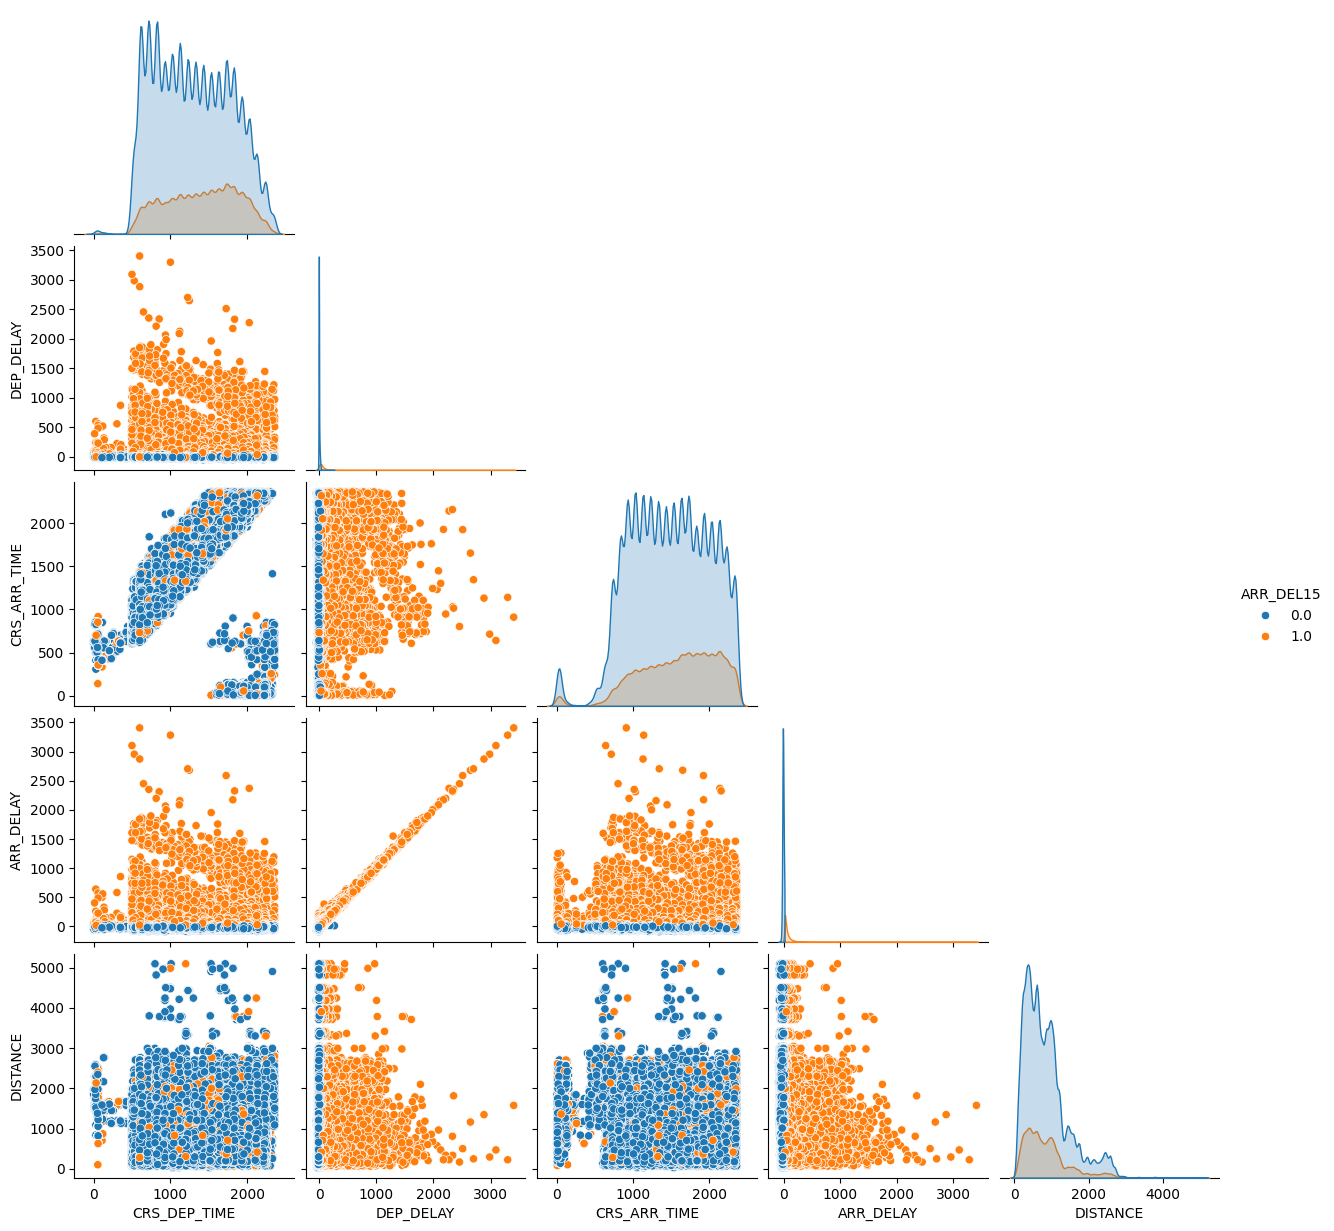

In [26]:
numeric_cols = ['CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 'DISTANCE']

sns.pairplot(df[numeric_cols + ['ARR_DEL15']], hue='ARR_DEL15', corner=True)
plt.show()


Strong linear relationship: Departure delay directly predicts arrival delay
*   Multicollinearity: Some time variables are highly correlated - consider removing redundant features

*    Longer flights → bigger delay risk?
*    Certain departure times, more delays?
*    Outliers in delay times.

/tmp/ipython-input-3764308137.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])


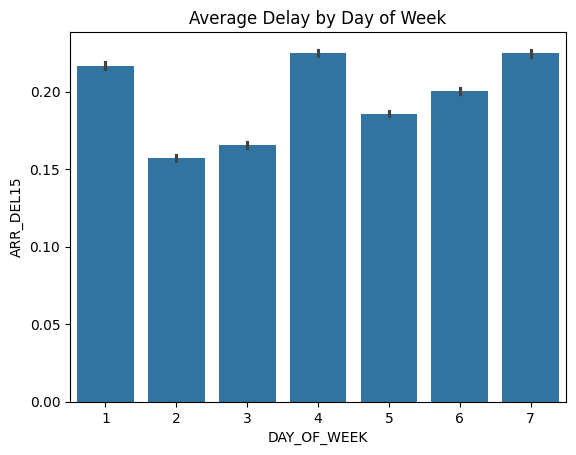

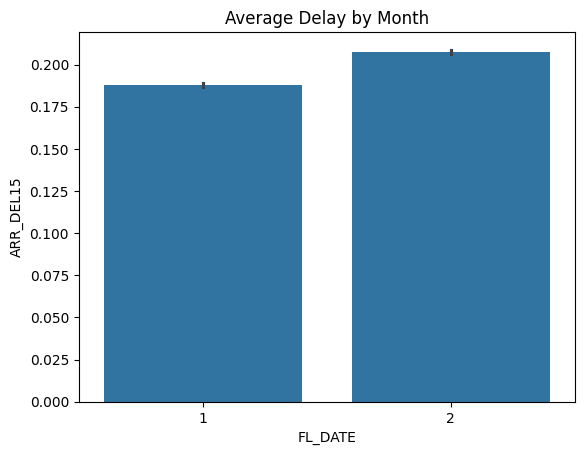

In [28]:
# Convert FL_DATE to datetime
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Delays by day of week
sns.barplot(x='DAY_OF_WEEK', y='ARR_DEL15', data=df)
plt.title('Average Delay by Day of Week')
plt.show()

# Delays by month (Jan vs Feb)
sns.barplot(x=df['FL_DATE'].dt.month, y='ARR_DEL15', data=df)
plt.title('Average Delay by Month')
plt.show()


- Are weekends more delayed?
  - if monday is 1 then it looks like Monday Thursday and Sunday have most frequent delays. which makes sense sind monday and tuesday are typical consultant days and sunddays additional to increased weekend travels.   
- Does one month show a higher delay rate?
  - it seams like february has slightly higher delay rate

In [ ]:
# Top 10 origin airports with highest delay %
origin_delay = df.groupby('ORIGIN')['ARR_DEL15'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=origin_delay.values, y=origin_delay.index)
plt.title('Top 10 Origin Airports by Delay Rate')
plt.show()

# Top carriers
carrier_delay = df.groupby('OP_CARRIER')['ARR_DEL15'].mean().sort_values(ascending=False)
sns.barplot(x=carrier_delay.values, y=carrier_delay.index)
plt.title('Carrier Delay Rate')
plt.show()


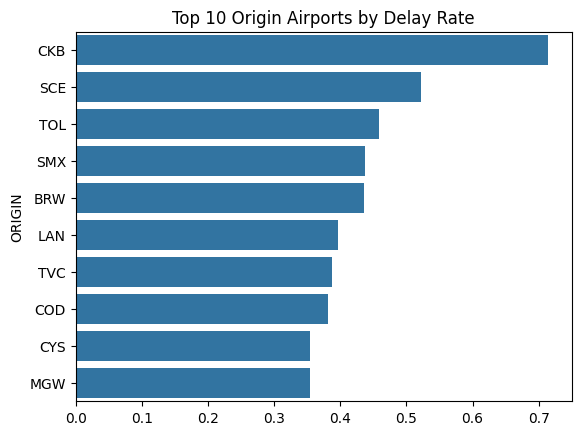

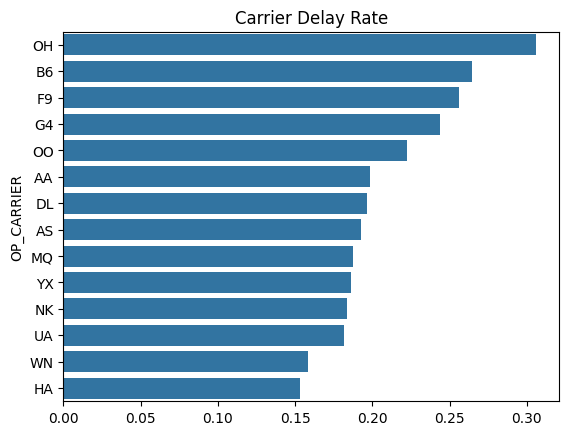

In [29]:
# Top 10 origin airports with highest delay %
origin_delay = df.groupby('ORIGIN')['ARR_DEL15'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=origin_delay.values, y=origin_delay.index)
plt.title('Top 10 Origin Airports by Delay Rate')
plt.show()

# Top carriers
carrier_delay = df.groupby('OP_CARRIER')['ARR_DEL15'].mean().sort_values(ascending=False)
sns.barplot(x=carrier_delay.values, y=carrier_delay.index)
plt.title('Carrier Delay Rate')
plt.show()


- Quickly identifies which airports or carriers are risk factors.

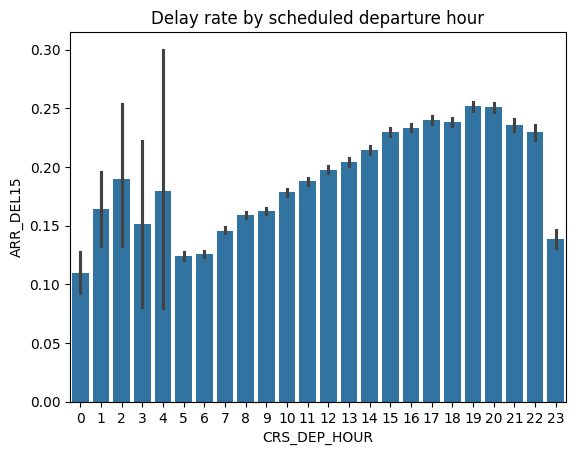

In [30]:
# Extract hour
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100

sns.barplot(x='CRS_DEP_HOUR', y='ARR_DEL15', data=df)
plt.title('Delay rate by scheduled departure hour')
plt.show()

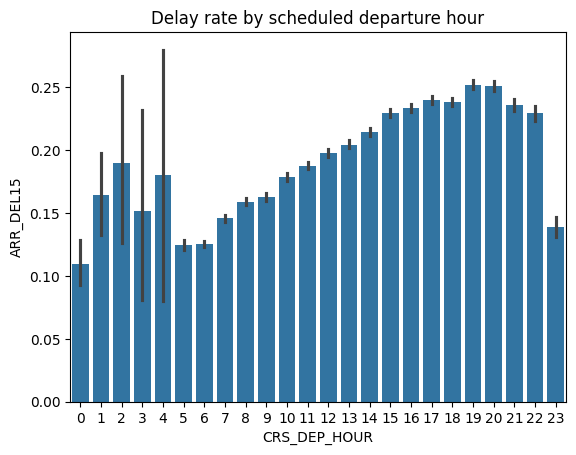

In [11]:
# Extract hour
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100

plt.title('Delay rate by scheduled departure hour')
sns.barplot(data=df, x='CRS_DEP_HOUR', y='ARR_DEL15',
            errorbar='ci')  # or errorbar=('ci', 95)
plt.show()

Delays compound throughout the day as inbound flight delays propagate through the network.

**Why are the confidence intervals so large from `CRS_DEP_HOUR` 0-4?**

For `CRS_DEP_HOUR` between 0 and 4, the confidence intervals are likely large because there are significantly fewer flights scheduled during these hours compared to other times of the day. With fewer data points, the estimate of the mean delay rate is less precise, resulting in a wider confidence interval.

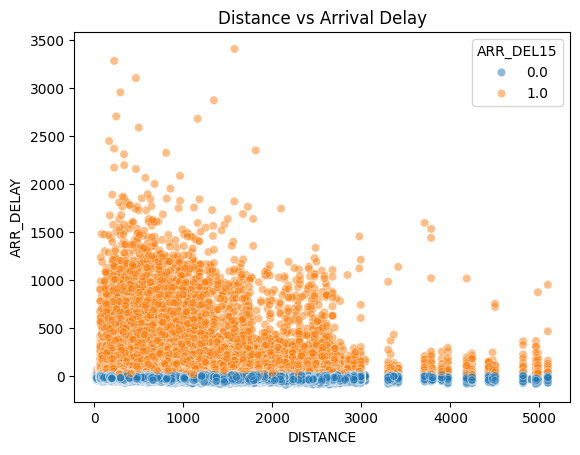

In [32]:
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', hue='ARR_DEL15', alpha=0.5, data=df)
plt.title('Distance vs Arrival Delay')
plt.show()

- check if longer flights accumulate more delays, or if distance is not strongly predictive.
  - not really predictive

- the scattered clusters around longer distances are due to the available longdistance airports and there are only so many airports that fly those routes

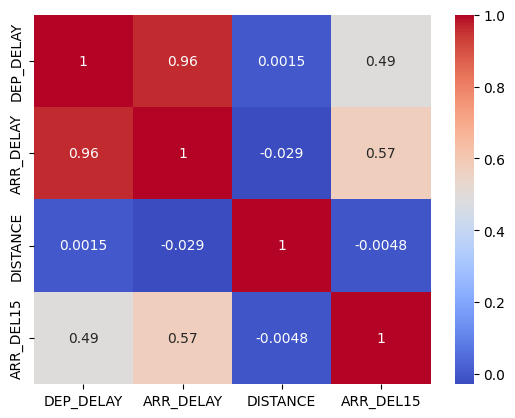

In [33]:
corr = df[['DEP_DELAY','ARR_DELAY','DISTANCE','ARR_DEL15']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
departure delay → arrival delay

## High-level insights:

1. Certain carriers and airports have higher delay rates.

2. Late afternoon/evening departures are more likely to be delayed.

3. Departure delay is highly predictive of arrival delay (obvious but important to confirm).

4. Day-of-week effects: weekends might be better/worse.

5. Distance alone is not a strong predictor, but can interact with other features.

**What causes departure delays?**

- Inbound Flight Delays
- weather,
  - Reduced visibility requiring increased spacing between - departures
  - crosswinds
  - de-icing proceedures
  - Ground stops or airspace closures

- Volume delays
  - Too many flights for available airspace/runways
  - Ground delay programs to manage congestion
  - Reroutes due to weather or military airspace
  - Staffing shortages at busy facilities

- Mechanical issues
  - Unscheduled maintenance discovered during pre-flight
  - Equipment failures
  - Required safety checks
  - Waiting for replacement aircraft

- Crew Issues
  - Crew not available - Previous flight delayed or crew timing out
  - Crew rest requirements (FAA mandated)
  - Crew scheduling conflicts
  - Waiting for replacement crew

- Gate/Ground Operations
  - Gate not available (previous aircraft hasn't left)
  - Baggage loading delays
  - Fueling delays
  - Catering delays
  - Ground equipment failures (jetway, tug, de-icing truck)

- Passenger/Boarding Issues

  - Late-arriving passengers (especially connections)
  - Passengers requiring special assistance
  - Oversold flights (volunteer/involuntary denied boarding)
  - Disruptive passengers requiring removal
  - Medical emergencies before departure

- Airport Congestion

  - Runway closures for maintenance
  - Limited gates at hub airports
  - Taxi delays during peak hours
  - Departure queue length

- Security Issues

  - Unattended bags requiring investigation
  - TSA checkpoint delays affecting crew
  - Suspicious activity holding aircraft
  - Security breaches closing terminals
  - Drones

- Airline Operational Decisions

  - Schedule padding - Intentionally tight schedules to maximize aircraft utilization
  - Holding flights for connecting passengers
  - Consolidating flights (canceling one, moving passengers)
  - Weight/balance issues requiring cargo/passenger adjustments



**What Airlines Can Control vs Cannot:**

Can Control:

- Schedule padding/buffers
- Crew scheduling practices
- Aircraft maintenance timing
- Ground operations efficiency
- Proactive rebooking

Cannot Control:

- Weather
- ATC decisions
- Airspace/runway availability
- Security incidents

# Feature Engineering

## Timebased features
- scheduled departure hour
- Scheduled arrival hour

- Weekday / weekend
- Month / seasonal

- Day of month / proximity to holidays


## Flight route features
- Route `ROUTE = ORIGIN + '-' + DEST`
- Distance bins `DISTANCE_BIN = pd.qcut(DISTANCE, q=5)` *distance bins that group flights into 5 categories based on flight distance, which helps capture patterns related to flight length*

## Carrier / aircraft features

- Carrier delay rate
- Tail number delay rate
- Flights per carrier per day/hour

## Departure delay as predictor

- DEP_DELAY is highly predictive for arrival delay. (This can only be a realtime predictor since its only available at departure)

- Binary feature: DEP_DEL15 (already in dataset)
- Interaction features: e.g., DEP_DELAY × DISTANCE

## Airport-level features

- Origin airport delay rate → some airports are more prone to delays
- Destination airport delay rate → some airports receive delayed flights
- Airport congestion features → number of flights departing per hour/day

## External data (optional high-impact)
- Weather: precipitation, wind speed, visibility at origin/destination
- Public holidays / school breaks → more passengers → higher congestion
- Inbound flight delay → delays propagate across the network
- Strike / airline labor disruptions? sickness rates, etc?



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- 1. Load & combine datasets ---
df_jan = pd.read_csv( basePath / "flights_jan_2025.csv")
df_feb = pd.read_csv( basePath / "flights_feb_2025.csv")
df = pd.concat([df_jan, df_feb], ignore_index=True)

# --- 2. Clean data & target ---
df = df.dropna(subset=["ARR_DEL15"])  # remove rows without target
y = df["ARR_DEL15"]

# --- 3. Drop IDs / high-cardinality cols we won't encode directly ---
X = df.drop(["ARR_DEL15", "FL_DATE", "DEP_DELAY", "ARR_DELAY", "OP_CARRIER_FL_NUM", "TAIL_NUM"], axis=1)

# --- 4. Time-based features ---
X['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
X['DEP_HOUR'] = X['CRS_DEP_TIME'] // 100
X['ARR_HOUR'] = X['CRS_ARR_TIME'] // 100
X['MONTH'] = X['FL_DATE'].dt.month
X['IS_WEEKEND'] = X['DAY_OF_WEEK'].isin([6,7]).astype(int)

# Optional: proximity to holidays (placeholder)
# X['IS_HOLIDAY'] = 0  # Replace with holiday flag if available

# --- 5. Route feature ---
X['ROUTE'] = X['ORIGIN'] + '-' + X['DEST']
# Optional: could use frequency or historical delay rate encoding

# --- 6. Distance bins ---
X['DIST_BIN'] = pd.qcut(X['DISTANCE'], q=5, labels=False)

# --- 7. Categorical encoding ---
cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'ROUTE']
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# --- 8. Departure delay feature ---
# Include DEP_DEL15 if treating model as real-time predictor at departure
X['DEP_DEL15'] = df['DEP_DEL15']

# Optional: interaction with distance
X['DEP_DELAY_X_DIST'] = df['DEP_DELAY'].fillna(0) * df['DISTANCE']

# --- 9. Airport & carrier historical delay rates (simplified example) ---
# Group by origin airport
origin_delay = df.groupby('ORIGIN')['ARR_DEL15'].mean()
X['ORIGIN_DELAY_RATE'] = df['ORIGIN'].map(origin_delay)

# Group by destination airport
dest_delay = df.groupby('DEST')['ARR_DEL15'].mean()
X['DEST_DELAY_RATE'] = df['DEST'].map(dest_delay)

# Group by carrier
carrier_delay = df.groupby('OP_CARRIER')['ARR_DEL15'].mean()
X['CARRIER_DELAY_RATE'] = df['OP_CARRIER'].map(carrier_delay)

# --- 10. Optional external data placeholders ---
# X['STRIKE_DAY'] = 0  # Replace with strike flag if available
# X['WEATHER_SCORE'] = 0  # Replace with weather-based risk metric



# --- 11. Quick check ---
print("Features ready for modeling:", X.columns)
print("Shape:", X.shape)


/tmp/ipython-input-142741201.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['FL_DATE'] = pd.to_datetime(df['FL_DATE'])


Features ready for modeling: Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_DEL15', 'CRS_ARR_TIME',
       'CANCELLED', 'DIVERTED', 'DISTANCE', 'FL_DATE', 'DEP_HOUR', 'ARR_HOUR',
       'MONTH', 'IS_WEEKEND', 'ROUTE', 'DIST_BIN', 'DEP_DELAY_X_DIST',
       'ORIGIN_DELAY_RATE', 'DEST_DELAY_RATE', 'CARRIER_DELAY_RATE'],
      dtype='object')
Shape: (1018745, 23)


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.929911
AUC: 0.9299114660965653
Accuracy: 0.9233419550525401
F1: 0.7784507581667826


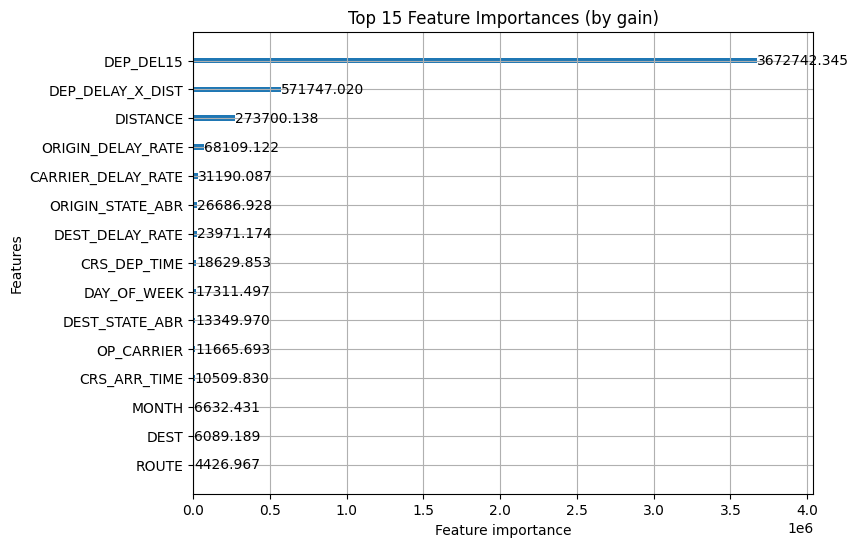

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# --- 1. Train-test split ---
# Drop the 'FL_DATE' column as LightGBM cannot handle datetime objects directly.
X = X.drop('FL_DATE', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. LightGBM dataset ---
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# --- 3. LightGBM parameters ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# --- 4. Train model with early stopping ---
callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=True)]
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

# --- 5. Evaluate ---
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC:", roc_auc_score(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred_bin))
print("F1:", f1_score(y_val, y_pred_bin))

# --- 6. Feature importance ---
ax = lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(8,6))
plt.title("Top 15 Feature Importances (by gain)")
plt.show()

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.664525
AUC without DEP_DEL15: 0.664524621228722
Accuracy without DEP_DEL15: 0.8040873820239609
F1 without DEP_DEL15: 0.03332283922214419


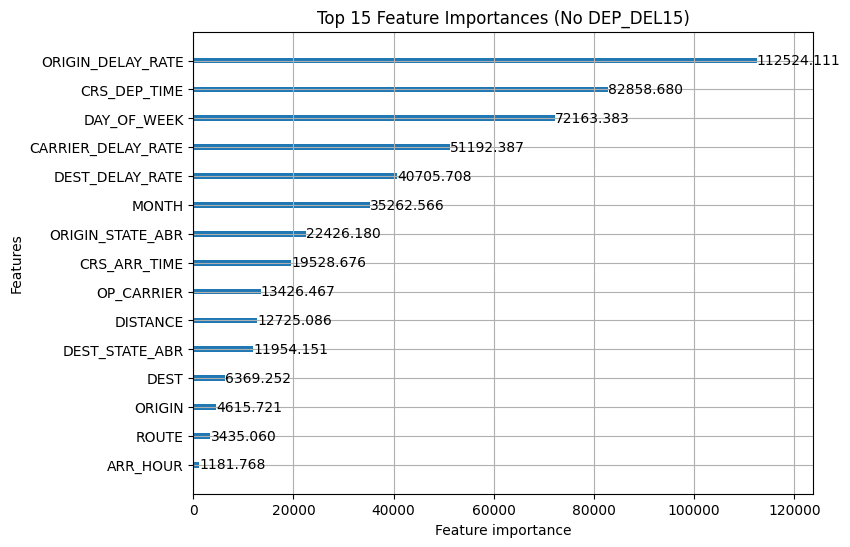

In [3]:
# --- 0. Remove DEP_DEL15 from features ---
X_no_dep_flag = X.drop(columns=['DEP_DEL15', 'DEP_DELAY_X_DIST'])

# --- 1. Train-test split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_no_dep_flag, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. LightGBM dataset ---
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# --- 3. LightGBM parameters (same as before) ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# --- 4. Train model ---
callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=True)]
model_no_dep_flag = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

# --- 5. Evaluate ---
y_pred = model_no_dep_flag.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC without DEP_DEL15:", roc_auc_score(y_val, y_pred))
print("Accuracy without DEP_DEL15:", accuracy_score(y_val, y_pred_bin))
print("F1 without DEP_DEL15:", f1_score(y_val, y_pred_bin))

# --- 6. Feature importance ---
ax = lgb.plot_importance(model_no_dep_flag, max_num_features=15, importance_type='gain', figsize=(8,6))
plt.title("Top 15 Feature Importances (No DEP_DEL15)")
plt.show()


# Additional data Weather + Holidays


In [4]:
!pip install meteostat pandas

In [5]:
from meteostat import Point, Hourly
import pandas as pd

# Example: JFK airport coordinates
jfk = Point(40.6413, -73.7781)

# Convert FL_DATE to datetime
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
# Create a column for the departure hour as an integer for merging
df['DEP_HOUR_MERGE'] = df['CRS_DEP_TIME'] // 100

# Fetch hourly weather for the date range
start = df['FL_DATE'].min()
end = df['FL_DATE'].max()
weather = Hourly(jfk, start, end).fetch()

# Create separate date and hour columns in weather DataFrame for merging
weather['weather_date'] = weather.index.date
weather['weather_hour'] = weather.index.hour

# Merge on date and the integer departure hour
df = df.merge(
    weather[['temp', 'wspd', 'prcp', 'pres', 'tsun', 'weather_date', 'weather_hour']],  # pick features you want and include merge columns
    left_on=[df['FL_DATE'].dt.date, df['DEP_HOUR_MERGE']],
    right_on=['weather_date', 'weather_hour'],
    how='left'
)

# Drop the temporary merge columns from df and weather
df = df.drop('DEP_HOUR_MERGE', axis=1)
weather = weather.drop(['weather_date', 'weather_hour'], axis=1)

In [6]:
weather

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2025-01-01 00:00:00,9.4,5.6,77.0,0.0,<NA>,90.0,25.9,<NA>,1006.9,<NA>,9.0
2025-01-01 01:00:00,10.0,6.2,77.0,0.0,<NA>,90.0,25.9,<NA>,1004.9,<NA>,9.0
2025-01-01 02:00:00,10.6,6.7,77.0,4.8,<NA>,90.0,31.7,<NA>,1002.4,<NA>,9.0
2025-01-01 03:00:00,10.0,7.8,86.0,4.8,<NA>,100.0,42.5,<NA>,1001.2,<NA>,9.0
2025-01-01 04:00:00,10.6,8.9,89.0,4.8,<NA>,90.0,29.5,<NA>,999.6,<NA>,8.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27 20:00:00,8.3,5.1,80.0,0.0,<NA>,210.0,18.4,<NA>,1003.4,<NA>,4.0
2025-02-27 21:00:00,8.3,6.1,86.0,0.0,<NA>,0.0,0.0,<NA>,1002.6,<NA>,4.0
2025-02-27 22:00:00,10.0,6.7,80.0,0.0,<NA>,250.0,11.2,<NA>,1002.7,<NA>,4.0


In [7]:
# Load CSV with proper handling of empty strings
airports = pd.read_csv(
     basePath / "airports.csv",
    keep_default_na=True,  # Treat empty fields as NaN
    na_values=['', 'NA', 'N/A', 'null'],  # Additional values to treat as NaN
    dtype=str  # Load all columns as strings first to avoid type issues
)

# Convert numeric columns to proper types
airports['latitude_deg'] = pd.to_numeric(airports['latitude_deg'], errors='coerce')
airports['longitude_deg'] = pd.to_numeric(airports['longitude_deg'], errors='coerce')
airports['elevation_ft'] = pd.to_numeric(airports['elevation_ft'], errors='coerce')

# Now filter for US airports with IATA codes
# IATA codes will be NaN for empty fields
us_airports = airports[
    (airports['iso_country'] == 'US') &
    (airports['iata_code'].notna()) &
    (airports['iata_code'].str.strip() != '')  # Also exclude empty strings if any remain
]

print(f"Total airports: {len(airports)}")
print(f"US airports with IATA codes: {len(us_airports)}")
print("\n--- Sample ---")
print(us_airports[['name', 'iata_code', 'municipality', 'type']].head(10))

Total airports: 83798
US airports with IATA codes: 2037

--- Sample ---
                               name iata_code     municipality           type
410         Ocean Reef Club Airport       OCA        Key Largo  small_airport
632           Crested Butte Airpark       CSE    Crested Butte  small_airport
888                Columbus Airport       CUS         Columbus  small_airport
985               LBJ Ranch Airport       JCY        Stonewall  small_airport
1283           Loring Seaplane Base       WLR           Loring  seaplane_base
1384            Nunapitchuk Airport       NUP      Nunapitchuk  small_airport
1402       Port Alice Seaplane Base       PTC       Port Alice  seaplane_base
1545                Icy Bay Airport       ICY          Icy Bay  small_airport
1574  Port Protection Seaplane Base       PPV  Port Protection  seaplane_base
1776     Kalakaket Creek AS Airport       KKK  Kalakaket Creek  small_airport


In [8]:
airports

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83793,32753,ZYYY,medium_airport,Shenyang Dongta Airport,41.784354,123.496308,157.0,AS,CN,CN-21,"Dadong, Shenyang",no,ZYYY,NaN,ZYYY,NaN,NaN,NaN,"东塔机场, SHE"
83794,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,NaN,http://www.sealandgov.org/,https://en.wikipedia.org/wiki/Principality_of_...,Roughs Tower Helipad
83795,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83796,346788,ZZ-0003,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,NaN,US,US-TX,Blum,no,NaN,NaN,87TX,87TX,NaN,NaN,NaN


In [9]:
# us_airports = airports[(airports['iso_country'] == 'US') & (airports['iata_code'].notna())]


In [10]:
# # Check total airports in the dataset
# print(f"Total airports in dataset: {len(airports)}")

# # Check how many are in the US
# print(f"US airports (all): {len(airports[airports['iso_country'] == 'US'])}")

# # Check how many have IATA codes (regardless of country)
# print(f"Airports with IATA codes (all countries): {len(airports[airports['iata_code'].notna()])}")

# # Check the final filtered result
# print(f"US airports with IATA codes: {len(us_airports)}")

# # Look at some examples of what's being filtered out
# print("\n--- Sample of US airports WITHOUT IATA codes ---")
# print(airports[(airports['iso_country'] == 'US') & (airports['iata_code'].isna())][['name', 'iata_code', 'type']].head(10))

# # Check the data types
# print("\n--- Column info ---")
# print(airports[['iso_country', 'iata_code']].info())

# # Check for potential issues with the iso_country column
# print("\n--- Unique country codes (first 20) ---")
# print(airports['iso_country'].unique()[:20])


In [11]:
# # Handle both NaN and empty strings, strip whitespace
# us_airports = airports[
#     (airports['iso_country'].str.strip().str.upper() == 'US') &
#     (airports['iata_code'].notna()) &
#     (airports['iata_code'].str.strip() != '')
# ]

# print(f"US airports with IATA codes: {len(us_airports)}")

In [12]:
# # Check the exact column names
# print("Column names in dataset:")
# print(airports.columns.tolist())

# # Check first few rows to see the actual data
# print("\n--- First 10 rows ---")
# print(airports.head(10))

# # Look specifically at US airports
# print("\n--- Sample of rows where iso_country contains 'US' ---")
# print(airports[airports['iso_country'].str.contains('US', na=False)].head(20))

# # Check for variations in country code (handle NaN)
# print("\n--- All unique values in iso_country column ---")
# print(airports['iso_country'].value_counts(dropna=False).head(30))

# # Check IATA code column more carefully
# print("\n--- Sample of IATA codes ---")
# print(airports['iata_code'].head(20))
# print(f"\nIATA code data type: {airports['iata_code'].dtype}")

# # Check for empty strings vs NaN
# print(f"\nRows with NaN in iata_code: {airports['iata_code'].isna().sum()}")
# print(f"Rows with empty string in iata_code: {(airports['iata_code'] == '').sum()}")

# # Try filtering with just US first
# us_only = airports[airports['iso_country'] == 'US']
# print(f"\n--- Total US airports: {len(us_only)} ---")
# print(us_only[['name', 'iata_code', 'type']].head(20))

# # Check how many US airports have non-null IATA
# print(f"\nUS airports with non-null IATA: {us_only['iata_code'].notna().sum()}")
# print(f"US airports with null IATA: {us_only['iata_code'].isna().sum()}")

In [13]:
# Keep only US airports with IATA code
us_airports = us_airports[['iata_code', 'latitude_deg', 'longitude_deg', 'type']]

# Quick check
print(us_airports.head())
print(us_airports.shape)


     iata_code  latitude_deg  longitude_deg           type
410        OCA     25.325399     -80.274803  small_airport
632        CSE     38.851918    -106.928341  small_airport
888        CUS     31.823898    -107.629924  small_airport
985        JCY     30.251801     -98.622498  small_airport
1283       WLR     55.601299    -131.636993  seaplane_base
(2037, 4)


In [14]:
# df['ORIGIN'] = df['ORIGIN'].str.strip().str.upper()
# df['DEST'] = df['DEST'].str.strip().str.upper()
# us_airports['iata_code'] = us_airports['iata_code'].str.strip().str.upper()


In [15]:
# Keep only relevant columns for merging
airport_info = us_airports[['iata_code', 'latitude_deg', 'longitude_deg', 'type']]

# --- Merge origin info ---
origin_info = airport_info.rename(columns={
    'iata_code': 'ORIGIN',
    'latitude_deg': 'ORIGIN_LAT',
    'longitude_deg': 'ORIGIN_LON',
    'type': 'ORIGIN_TYPE'
})

df = df.drop(columns=['ORIGIN_LAT', 'ORIGIN_LON', 'ORIGIN_TYPE'], errors='ignore')  # drop if they exist
df = df.merge(origin_info, on='ORIGIN', how='left')

# --- Merge destination info ---
dest_info = airport_info.rename(columns={
    'iata_code': 'DEST',
    'latitude_deg': 'DEST_LAT',
    'longitude_deg': 'DEST_LON',
    'type': 'DEST_TYPE'
})

df = df.drop(columns=['DEST_LAT', 'DEST_LON', 'DEST_TYPE'], errors='ignore')  # drop if they exist
df = df.merge(dest_info, on='DEST', how='left')

# Quick check
print(df[['ORIGIN', 'ORIGIN_LAT', 'ORIGIN_TYPE', 'DEST', 'DEST_LAT', 'DEST_TYPE']].head())


  ORIGIN  ORIGIN_LAT    ORIGIN_TYPE DEST   DEST_LAT      DEST_TYPE
0    SFO   37.619806  large_airport  JFK  40.639447  large_airport
1    JFK   40.639447  large_airport  SFO  37.619806  large_airport
2    CLT   35.214001  large_airport  LGA  40.777199  large_airport
3    AUS   30.197535  large_airport  CLT  35.214001  large_airport
4    CLT   35.214001  large_airport  AUS  30.197535  large_airport


In [16]:
df.head()

,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,pres,tsun,weather_date,weather_hour,ORIGIN_LAT,ORIGIN_LON,ORIGIN_TYPE,DEST_LAT,DEST_LON,DEST_TYPE
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,1014.4,<NA>,2025-01-06,13,37.619806,-122.374821,large_airport,40.639447,-73.779317,large_airport
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,1017.4,<NA>,2025-01-06,8,40.639447,-73.779317,large_airport,37.619806,-122.374821,large_airport
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,1008.9,<NA>,2025-01-06,18,35.214001,-80.943100,large_airport,40.777199,-73.872597,large_airport
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,1014.4,<NA>,2025-01-06,13,30.197535,-97.662015,large_airport,35.214001,-80.943100,large_airport
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,1015.7,<NA>,2025-01-06,11,35.214001,-80.943100,large_airport,30.197535,-97.662015,large_airport


In [18]:
df.columns

Index(['DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'CRS_DEP_TIME',
       'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DEL15',
       'CANCELLED', 'DIVERTED', 'DISTANCE', 'temp', 'wspd', 'prcp', 'pres',
       'tsun', 'weather_date', 'weather_hour', 'ORIGIN_LAT', 'ORIGIN_LON',
       'ORIGIN_TYPE', 'DEST_LAT', 'DEST_LON', 'DEST_TYPE'],
      dtype='object')

In [19]:
import os
import pandas as pd
from meteostat import Point, Hourly
from tqdm import tqdm
import numpy as np

# --- CONFIG ---
CACHE_FILE =  basePath / "airport_weather_cache.csv"

# --- 1️⃣ Prepare dataset ---
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DEP_HOUR'] = (df['CRS_DEP_TIME'] // 100).astype(int)
df['ARR_HOUR'] = (df['CRS_ARR_TIME'] // 100).astype(int)

start = df['FL_DATE'].min()
end = df['FL_DATE'].max()

# --- 2️⃣ Load or fetch weather ---
if os.path.exists(CACHE_FILE):
    print("✅ Loading cached weather data...")
    weather_df = pd.read_csv(CACHE_FILE, parse_dates=['time'])
else:
    print("🌦️ Fetching weather data for all airports (this may take a few minutes)...")

    airport_coords = pd.concat([
        df[['ORIGIN', 'ORIGIN_LAT', 'ORIGIN_LON']],
        df[['DEST', 'DEST_LAT', 'DEST_LON']].rename(columns={'DEST':'ORIGIN','DEST_LAT':'ORIGIN_LAT','DEST_LON':'ORIGIN_LON'})
    ], ignore_index=True).drop_duplicates(subset=['ORIGIN']).dropna(subset=['ORIGIN_LAT','ORIGIN_LON'])

    weather_data = []
    for _, row in tqdm(airport_coords.iterrows(), total=len(airport_coords)):
        code, lat, lon = row['ORIGIN'], row['ORIGIN_LAT'], row['ORIGIN_LON']
        try:
            point = Point(lat, lon)
            w = Hourly(point, start, end).fetch()
            if w is not None and not w.empty:
                w = w[['temp', 'wspd', 'prcp', 'pres']]
                w['airport'] = code
                w['weather_date'] = w.index.date
                w['weather_hour'] = w.index.hour
                weather_data.append(w.reset_index())
        except Exception as e:
            print(f"⚠️ Weather fetch failed for {code}: {e}")

    weather_df = pd.concat(weather_data, ignore_index=True)
    weather_df.to_csv(CACHE_FILE, index=False)
    print(f"✅ Weather data cached to {CACHE_FILE}")

# --- 3️⃣ Merge Origin weather ---
df['weather_date'] = df['FL_DATE'].dt.date
origin_weather = weather_df.rename(columns={
    'airport': 'ORIGIN',
    'temp': 'ORIGIN_TEMP',
    'wspd': 'ORIGIN_WSPD',
    'prcp': 'ORIGIN_PRCP',
    'pres': 'ORIGIN_PRES'
})

df = df.merge(
    origin_weather[['ORIGIN', 'weather_date', 'weather_hour', 'ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES']],
    left_on=['ORIGIN', 'weather_date', 'DEP_HOUR'],
    right_on=['ORIGIN', 'weather_date', 'weather_hour'],
    how='left'
).drop(columns=['weather_hour'], errors='ignore')

# --- 4️⃣ Merge Destination weather ---
dest_weather = weather_df.rename(columns={
    'airport': 'DEST',
    'temp': 'DEST_TEMP',
    'wspd': 'DEST_WSPD',
    'prcp': 'DEST_PRCP',
    'pres': 'DEST_PRES'
})

df = df.merge(
    dest_weather[['DEST', 'weather_date', 'weather_hour', 'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']],
    left_on=['DEST', 'weather_date', 'ARR_HOUR'],
    right_on=['DEST', 'weather_date', 'weather_hour'],
    how='left'
).drop(columns=['weather_hour'], errors='ignore')

# --- 5️⃣ Cleanup ---
df.drop(columns=['weather_date'], inplace=True, errors='ignore')

print("✅ Weather columns added:")
print([c for c in df.columns if 'TEMP' in c or 'WSPD' in c or 'PRCP' in c or 'PRES' in c])
print("✅ Final shape:", df.shape)


🌦️ Fetching weather data for all airports (this may take a few minutes)...


100%|██████████| 322/322 [14:51<00:00,  2.77s/it]


✅ Weather data cached to /content/flight-data/airport_weather_cache.csv
✅ Weather columns added:
['ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES', 'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']
✅ Final shape: (1018745, 41)


In [20]:
df.head()

,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,ARR_HOUR,weather_hour_y,ORIGIN_TEMP,ORIGIN_WSPD,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,21,13.0,8.9,0.0,0.0,1023.5,-0.6,18.4,0.0,1005.7
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,12,8.0,-0.6,16.6,0.0,1017.4,9.4,0.0,0.0,1024.0
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,20,18.0,3.9,5.4,0.0,1004.3,-1.0,13.0,0.0,1006.0
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,17,13.0,-1.7,33.5,0.0,1029.3,3.3,0.0,0.0,1005.2
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,13,11.0,1.7,7.6,0.5,1009.6,-1.7,33.5,0.0,1029.3


In [22]:
weather_cols = ['ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES',
                'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']

# Count NaNs per column
na_counts = df[weather_cols].isna().sum()
print(na_counts)

# Optional: total number of rows with any NaN in weather
total_na_rows = df[weather_cols].isna().any(axis=1).sum()
print("Total rows with any missing weather data:", total_na_rows)

ORIGIN_TEMP    29320
ORIGIN_WSPD    29320
ORIGIN_PRCP    36804
ORIGIN_PRES    29321
DEST_TEMP      29004
DEST_WSPD      29004
DEST_PRCP      36386
DEST_PRES      29004
dtype: int64
Total rows with any missing weather data: 53346


ValueError: cannot convert NA to integer

In [23]:
df['WEATHER_MISSING'] = df[weather_cols].isna().any(axis=1).astype(int)

In [24]:
df['WEATHER_MISSING'] = df[weather_cols].isna().any(axis=1).astype(int)
weather_cols = ['ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES',
                'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']

for col in weather_cols:
    df[col] = df[col].fillna(0)

In [25]:
df['WEATHER_RISK_ORIGIN'] = (
    (df['ORIGIN_PRCP'] > 0.5).astype(int) +
    (df['ORIGIN_WSPD'] > 20).astype(int)
)
df['WEATHER_RISK_DEST'] = (
    (df['DEST_PRCP'] > 0.5).astype(int) +
    (df['DEST_WSPD'] > 20).astype(int)
)

In [26]:
output_path =  basePath / "flights_with_weather.csv"  # replace with your preferred path

# --- Save the DataFrame ---
df.to_csv(output_path, index=False)

print(f" Dataset saved to {output_path}")

✅ Dataset saved to /content/flight-data/flights_with_weather.csv


In [27]:
from google.colab import files
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.924078
AUC: 0.9241
Accuracy: 0.9115
F1 Score: 0.7719


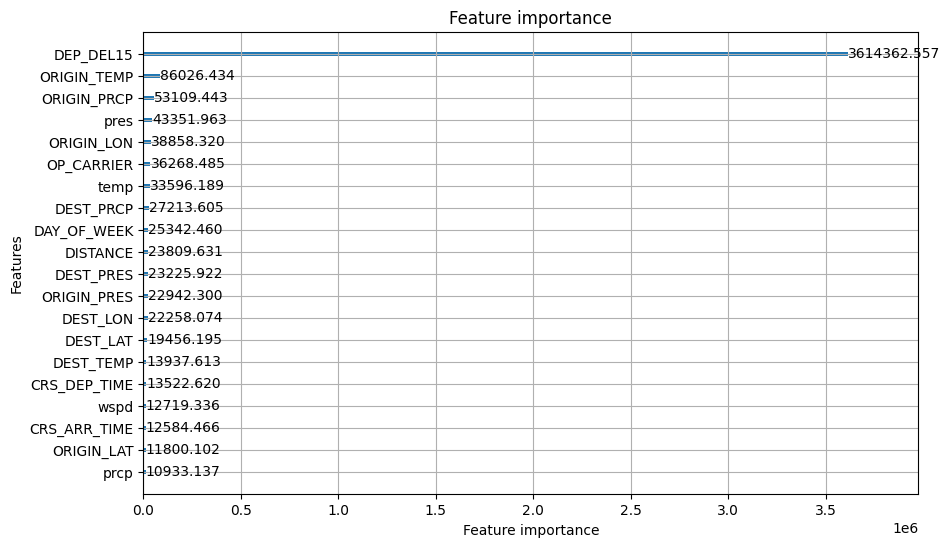

In [29]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# --- 1️⃣ Load the enriched CSV ---
df = pd.read_csv( basePath / "flights_with_weather.csv")

# --- 2️⃣ Drop rows with missing target ---
df = df.dropna(subset=['ARR_DEL15'])
y = df['ARR_DEL15']

# --- 3️⃣ Drop leakage or high-cardinality cols ---
drop_cols = [
    'ARR_DEL15', 'FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'OP_CARRIER_FL_NUM', 'TAIL_NUM'
]
X = df.drop(columns=drop_cols, errors='ignore')

# --- 4️⃣ Encode categorical features ---
cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST',
            'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'ROUTE', 'ORIGIN_TYPE', 'DEST_TYPE'] # Added airport type columns
for col in cat_cols:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# --- 5️⃣ Split train/validation ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Prepare LightGBM datasets ---
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# --- 7️⃣ LightGBM parameters ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# --- 8️⃣ Train model with early stopping ---
callbacks = [lgb.early_stopping(stopping_rounds=20)]
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

# --- 9️⃣ Predict & evaluate ---
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC:", round(roc_auc_score(y_val, y_pred), 4))
print("Accuracy:", round(accuracy_score(y_val, y_pred_bin), 4))
print("F1 Score:", round(f1_score(y_val, y_pred_bin), 4))

# --- 🔟 Feature importance ---
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.show()

In [30]:
# Get importance values
importance_values = model.feature_importance(importance_type='gain')  # or 'split'
feature_names = model.feature_name()

# Combine into a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_values
})

# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(feature_importance_df.head(20))  # top 20 features

         feature    importance
7      DEP_DEL15  3.614363e+06
27   ORIGIN_TEMP  8.602643e+04
29   ORIGIN_PRCP  5.310944e+04
15          pres  4.335196e+04
19    ORIGIN_LON  3.885832e+04
1     OP_CARRIER  3.626849e+04
12          temp  3.359619e+04
33     DEST_PRCP  2.721360e+04
0    DAY_OF_WEEK  2.534246e+04
11      DISTANCE  2.380963e+04
34     DEST_PRES  2.322592e+04
30   ORIGIN_PRES  2.294230e+04
22      DEST_LON  2.225807e+04
21      DEST_LAT  1.945619e+04
31     DEST_TEMP  1.393761e+04
6   CRS_DEP_TIME  1.352262e+04
13          wspd  1.271934e+04
8   CRS_ARR_TIME  1.258447e+04
18    ORIGIN_LAT  1.180010e+04
14          prcp  1.093314e+04


In [32]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# --- 1️⃣ Load the enriched CSV ---
df = pd.read_csv( basePath / "flights_with_weather.csv")

# --- 2️⃣ Drop rows with missing target ---
df = df.dropna(subset=['ARR_DEL15'])
y = df['ARR_DEL15']

# --- 3️⃣ Drop leakage or high-cardinality cols, including DEP_DEL15 ---
drop_cols = [
    'ARR_DEL15', 'FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'OP_CARRIER_FL_NUM',
    'TAIL_NUM', 'DEP_DEL15'
]
X = df.drop(columns=drop_cols, errors='ignore')

# --- 4️⃣ Encode categorical features ---
cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST',
            'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'ROUTE', 'ORIGIN_TYPE', 'DEST_TYPE'] # Added airport type columns
for col in cat_cols:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))


# --- 5️⃣ Split train/validation ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Prepare LightGBM datasets ---
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# --- 7️⃣ LightGBM parameters ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# --- 8️⃣ Train model with early stopping ---
callbacks = [lgb.early_stopping(stopping_rounds=20)]
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

# --- 9️⃣ Predict & evaluate ---
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC:", round(roc_auc_score(y_val, y_pred), 4))
print("Accuracy:", round(accuracy_score(y_val, y_pred_bin), 4))
print("F1 Score:", round(f1_score(y_val, y_pred_bin), 4))

# --- 🔟 Feature importance ---
feature_importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(20))

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.743855
AUC: 0.7439
Accuracy: 0.8192
F1 Score: 0.2326
           feature     importance
14            pres  129598.715414
26     ORIGIN_TEMP  118228.610165
0      DAY_OF_WEEK  109225.937357
11            temp   88556.502579
28     ORIGIN_PRCP   73878.546453
6     CRS_DEP_TIME   72827.227489
18      ORIGIN_LON   64798.024490
1       OP_CARRIER   54694.881475
32       DEST_PRCP   46274.299347
33       DEST_PRES   34060.458666
29     ORIGIN_PRES   32334.438231
30       DEST_TEMP   28554.693062
13            prcp   28446.989651
12            wspd   27033.489002
21        DEST_LON   26074.053049
25  weather_hour_y   25828.484800
20        DEST_LAT   24634.029802
17      ORIGIN_LAT   23083.542213
7     CRS_ARR_TIME   21129.639612
27     ORIGIN_WSPD   15225.692596


In [33]:
df.head(
)

,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,ORIGIN_WSPD,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES,WEATHER_MISSING,WEATHER_RISK_ORIGIN,WEATHER_RISK_DEST
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,0.0,0.0,1023.5,-0.6,18.4,0.0,1005.7,0,0,0
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,16.6,0.0,1017.4,9.4,0.0,0.0,1024.0,0,0,0
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,5.4,0.0,1004.3,-1.0,13.0,0.0,1006.0,0,0,0
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,33.5,0.0,1029.3,3.3,0.0,0.0,1005.2,0,1,0
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,7.6,0.5,1009.6,-1.7,33.5,0.0,1029.3,0,0,1


In [22]:
# import os
# import zipfile
# import pandas as pd
# import requests
# from io import BytesIO




In [25]:

# master_path = basePath / "faa_registry/MASTER.txt"


# # 2. Read the MASTER file (which holds active registrations)
# # master_path = os.path.join("faa_registry", "MASTER.txt")
# # cols = ["N-NUMBER", "MFR MDL CODE", "Model", "YEAR MFR", "Type Aircraft"]  # adjust if the file uses different headers
# cols = ["N-NUMBER", "YEAR MFR"]  # adjust if the file uses different headers
# df_ac = pd.read_csv(
#     master_path,
#     sep=',',  # Comma separated
#     dtype=str,
#     encoding='utf-8',
#     low_memory=False,
#     skipinitialspace=True  # Skip whitespace after delimiter
# )

# # Strip whitespace from all string columns
# df_ac = df_ac.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# # Also strip column names
# df_ac.columns = df_ac.columns.str.strip()



# # 3. Select and rename the relevant columns
# df_ac2 = df_ac.rename(columns={
#     "N-NUMBER": "TAIL_NUM",
#     # "Mfr Name": "MANUFACTURER_NAME",
#     # "Model": "AIRCRAFT_MODEL",
#     "YEAR MFR": "MFR_YEAR",
#     # "Type Aircraft": "TYPE_AIRCRAFT"
# })[["TAIL_NUM", "MFR_YEAR"]]
# # })[["TAIL_NUM", "MANUFACTURER_NAME", "AIRCRAFT_MODEL", "MFR_YEAR", "TYPE_AIRCRAFT"]]

# # 4. Clean up tail numbers (uppercase, strip whitespace)
# df_ac2["TAIL_NUM"] = df_ac2["TAIL_NUM"].str.upper().str.strip()
# # Add 'N' prefix to TAIL_NUM if it's missing
# df_ac2['TAIL_NUM'] = df_ac2['TAIL_NUM'].apply(lambda x: 'N' + x if pd.notnull(x) and not str(x).startswith('N') else x)

# # Quick check
# print(df_ac2.head())

# # 5. Merge with your flights dataset
# df_flights = pd.read_csv( basePath / "flights_all_weather.csv", dtype=str)  # adjust path
# df = df_flights.merge(df_ac2, on="TAIL_NUM", how="left")

# # 6. Handle missing aircraft info (optional)
# # df["MANUFACTURER_NAME"] = df["MANUFACTURER_NAME"].fillna("UNKNOWN")
# # df["AIRCRAFT_MODEL"] = df["AIRCRAFT_MODEL"].fillna("UNKNOWN")
# df["MFR_YEAR"] = df["MFR_YEAR"].fillna("0").astype(int)
# # df["TYPE_AIRCRAFT"] = df["TYPE_AIRCRAFT"].fillna("UNKNOWN")

# df.head()
# # 7. Save the enriched dataset
# # df.to_csv("flights_with_aircraft_info.csv", index=False)
# # print("✅ Enriched flights dataset saved: flights_with_aircraft_info.csv")

  TAIL_NUM MFR_YEAR
0     N100     1940
1   N10000      NaN
2   N10001     1928
3   N10004      NaN
4   N10006     1955


In [26]:
# # 5. Merge with your flights dataset
# df_flights = pd.read_csv( basePath / "flights_all_weather.csv", dtype=str)  # adjust path
# df = df_flights.merge(df_ac2, on="TAIL_NUM", how="left")

# # 6. Handle missing aircraft info (optional)
# # df["MANUFACTURER_NAME"] = df["MANUFACTURER_NAME"].fillna("UNKNOWN")
# # df["AIRCRAFT_MODEL"] = df["AIRCRAFT_MODEL"].fillna("UNKNOWN")
# df["MFR_YEAR"] = df["MFR_YEAR"].fillna("0").astype(int)
# # df["TYPE_AIRCRAFT"] = df["TYPE_AIRCRAFT"].fillna("UNKNOWN")

# df.head()
# # 7. Save the enriched dataset
# # df.to_csv("flights_with_aircraft_info.csv", index=False)
# # print("✅ Enriched flights dataset saved: flights_with_aircraft_info.csv")


,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES,WEATHER_MISSING,WEATHER_RISK_ORIGIN,WEATHER_RISK_DEST,MFR_YEAR
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,0.0,1023.5,-0.6,18.4,0.0,1005.7,0,0,0,2013
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,0.0,1017.4,9.4,0.0,0.0,1024.0,0,0,0,2013
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,0.0,1004.3,-1.0,13.0,0.0,1006.0,0,0,0,1998
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,0.0,1029.3,3.3,0.0,0.0,1005.2,0,1,0,1998
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,0.5,1009.6,-1.7,33.5,0.0,1029.3,0,0,1,1998


In [ ]:
# # --- 4️⃣ Inbound flight delay (network propagation) ---
# # Sort by aircraft & scheduled departure
# df = df.sort_values(['TAIL_NUM', 'FL_DATE', 'CRS_DEP_TIME'])

# # Shift ARR_DEL15 and ARR_DELAY to get previous flight's delay
# df['INBOUND_DEL15'] = df.groupby('TAIL_NUM')['ARR_DEL15'].shift(1)
# df['INBOUND_ARR_DELAY'] = df.groupby('TAIL_NUM')['ARR_DELAY'].shift(1)

# # Fill missing for first flight of each aircraft
# df['INBOUND_DEL15'] = df['INBOUND_DEL15'].fillna(0)
# df['INBOUND_ARR_DELAY'] = df['INBOUND_ARR_DELAY'].fillna(0)

# Fresh Data Prep



In [13]:
!pip install meteostat

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
from meteostat import Point, Hourly
from tqdm import tqdm

In [27]:
# ============================================================================
# LOAD & PREPARE DATA
# ============================================================================

print("📁 Loading flight data...")
df_jan = pd.read_csv( basePath / "flights_jan_2025.csv")
df_feb = pd.read_csv( basePath / "flights_feb_2025.csv")
df = pd.concat([df_jan, df_feb], ignore_index=True)

# Load airport data
airports = pd.read_csv( basePath / "airports.csv", dtype=str, keep_default_na=True)
airports['latitude_deg'] = pd.to_numeric(airports['latitude_deg'], errors='coerce')
airports['longitude_deg'] = pd.to_numeric(airports['longitude_deg'], errors='coerce')

us_airports = airports[
    (airports['iso_country'] == 'US') &
    (airports['iata_code'].notna()) &
    (airports['iata_code'].str.strip() != '')
]

# Clean data
df = df.dropna(subset=["ARR_DEL15"])
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Standardize airport codes
df['ORIGIN'] = df['ORIGIN'].str.strip().str.upper()
df['DEST'] = df['DEST'].str.strip().str.upper()
us_airports['iata_code'] = us_airports['iata_code'].str.strip().str.upper()

📁 Loading flight data...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# ============================================================================
# MERGE AIRPORT COORDINATES & TYPE
# ============================================================================

print("🗺️ Adding airport metadata...")
airport_info = us_airports[['iata_code', 'latitude_deg', 'longitude_deg', 'type']]

# Origin info
origin_info = airport_info.rename(columns={
    'iata_code': 'ORIGIN',
    'latitude_deg': 'ORIGIN_LAT',
    'longitude_deg': 'ORIGIN_LON',
    'type': 'ORIGIN_TYPE'
})
df = df.drop(columns=['ORIGIN_LAT', 'ORIGIN_LON', 'ORIGIN_TYPE'], errors='ignore')
df = df.merge(origin_info, on='ORIGIN', how='left')

# Destination info
dest_info = airport_info.rename(columns={
    'iata_code': 'DEST',
    'latitude_deg': 'DEST_LAT',
    'longitude_deg': 'DEST_LON',
    'type': 'DEST_TYPE'
})
df = df.drop(columns=['DEST_LAT', 'DEST_LON', 'DEST_TYPE'], errors='ignore')
df = df.merge(dest_info, on='DEST', how='left')


🗺️ Adding airport metadata...


In [29]:
# ============================================================================
# FETCH & MERGE WEATHER DATA
# ============================================================================

print("🌦️ Processing weather data...")
CACHE_FILE =  basePath / "airport_weather_cache.csv"

df['DEP_HOUR'] = (df['CRS_DEP_TIME'] // 100).astype(int)
df['ARR_HOUR'] = (df['CRS_ARR_TIME'] // 100).astype(int)
start = df['FL_DATE'].min()
end = df['FL_DATE'].max()

if os.path.exists(CACHE_FILE):
    print("✅ Loading cached weather data...")
    weather_df = pd.read_csv(CACHE_FILE, parse_dates=['time'])
else:
    print("🌦️ Fetching weather data (this may take time)...")
    airport_coords = pd.concat([
        df[['ORIGIN', 'ORIGIN_LAT', 'ORIGIN_LON']],
        df[['DEST', 'DEST_LAT', 'DEST_LON']].rename(columns={
            'DEST':'ORIGIN', 'DEST_LAT':'ORIGIN_LAT', 'DEST_LON':'ORIGIN_LON'
        })
    ], ignore_index=True).drop_duplicates(subset=['ORIGIN']).dropna(subset=['ORIGIN_LAT','ORIGIN_LON'])

    weather_data = []
    for _, row in tqdm(airport_coords.iterrows(), total=len(airport_coords)):
        code, lat, lon = row['ORIGIN'], row['ORIGIN_LAT'], row['ORIGIN_LON']
        try:
            point = Point(lat, lon)
            w = Hourly(point, start, end).fetch()
            if w is not None and not w.empty:
                w = w[['temp', 'wspd', 'prcp', 'pres']]
                w['airport'] = code
                w['weather_date'] = w.index.date
                w['weather_hour'] = w.index.hour
                weather_data.append(w.reset_index())
        except Exception as e:
            print(f"⚠️ Weather fetch failed for {code}: {e}")

    weather_df = pd.concat(weather_data, ignore_index=True)
    weather_df.to_csv(CACHE_FILE, index=False)
    print(f"✅ Weather cached to {CACHE_FILE}")

# Merge origin weather
df['weather_date'] = df['FL_DATE'].dt.date
origin_weather = weather_df.rename(columns={
    'airport': 'ORIGIN', 'temp': 'ORIGIN_TEMP', 'wspd': 'ORIGIN_WSPD',
    'prcp': 'ORIGIN_PRCP', 'pres': 'ORIGIN_PRES'
})

df = df.merge(
    origin_weather[['ORIGIN', 'weather_date', 'weather_hour', 'ORIGIN_TEMP',
                    'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES']],
    left_on=['ORIGIN', 'weather_date', 'DEP_HOUR'],
    right_on=['ORIGIN', 'weather_date', 'weather_hour'],
    how='left'
).drop(columns=['weather_hour'], errors='ignore')

# Merge destination weather
dest_weather = weather_df.rename(columns={
    'airport': 'DEST', 'temp': 'DEST_TEMP', 'wspd': 'DEST_WSPD',
    'prcp': 'DEST_PRCP', 'pres': 'DEST_PRES'
})

df = df.merge(
    dest_weather[['DEST', 'weather_date', 'weather_hour', 'DEST_TEMP',
                  'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']],
    left_on=['DEST', 'weather_date', 'ARR_HOUR'],
    right_on=['DEST', 'weather_date', 'weather_hour'],
    how='left'
).drop(columns=['weather_hour', 'weather_date'], errors='ignore')

🌦️ Processing weather data...
🌦️ Fetching weather data (this may take time)...


100%|██████████| 322/322 [17:30<00:00,  3.26s/it]


✅ Weather cached to /content/drive/MyDrive/01-hash/airport_weather_cache.csv


In [30]:
# ============================================================================
# MERGE TAIL_NUMBER with Airplane Manufacturing year (can be extended to Airplane model, etc)
# ============================================================================
master_path = basePath / "faa_registry/MASTER.txt"

# 2. Read the MASTER file (which holds active registrations)
# master_path = os.path.join("faa_registry", "MASTER.txt")
# cols = ["N-NUMBER", "MFR MDL CODE", "Model", "YEAR MFR", "Type Aircraft"]  # adjust if the file uses different headers
cols = ["N-NUMBER", "YEAR MFR"]  # adjust if the file uses different headers
df_ac = pd.read_csv(
    master_path,
    sep=',',  # Comma separated
    dtype=str,
    encoding='utf-8',
    low_memory=False,
    skipinitialspace=True  # Skip whitespace after delimiter
)

# Strip whitespace from all string columns
df_ac = df_ac.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Also strip column names
df_ac.columns = df_ac.columns.str.strip()

# 3. Select and rename the relevant columns
df_ac2 = df_ac.rename(columns={
    "N-NUMBER": "TAIL_NUM",
    # "Mfr Name": "MANUFACTURER_NAME",
    # "Model": "AIRCRAFT_MODEL",
    "YEAR MFR": "MFR_YEAR",
    # "Type Aircraft": "TYPE_AIRCRAFT"
})[["TAIL_NUM", "MFR_YEAR"]]
# })[["TAIL_NUM", "MANUFACTURER_NAME", "AIRCRAFT_MODEL", "MFR_YEAR", "TYPE_AIRCRAFT"]]

# 4. Clean up tail numbers (uppercase, strip whitespace)
df_ac2["TAIL_NUM"] = df_ac2["TAIL_NUM"].str.upper().str.strip()
# Add 'N' prefix to TAIL_NUM if it's missing
df_ac2['TAIL_NUM'] = df_ac2['TAIL_NUM'].apply(lambda x: 'N' + x if pd.notnull(x) and not str(x).startswith('N') else x)

# Quick check
# print(df_ac2.head())

# 5. Merge with your flights dataset
# df_flights = pd.read_csv( basePath / "flights_all_weather.csv", dtype=str)  # adjust path
df = df.merge(df_ac2, on="TAIL_NUM", how="left")

# 6. Handle missing aircraft info (optional)
# df["MANUFACTURER_NAME"] = df["MANUFACTURER_NAME"].fillna("UNKNOWN")
# df["AIRCRAFT_MODEL"] = df["AIRCRAFT_MODEL"].fillna("UNKNOWN")
df["MFR_YEAR"] = df["MFR_YEAR"].fillna("0").astype(int)
# df["TYPE_AIRCRAFT"] = df["TYPE_AIRCRAFT"].fillna("UNKNOWN")

df.head()
# 7. Save the enriched dataset
# df.to_csv("flights_with_aircraft_info.csv", index=False)
# print("✅ Enriched flights dataset saved: flights_with_aircraft_info.csv")

,DAY_OF_WEEK,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,...,ARR_HOUR,ORIGIN_TEMP,ORIGIN_WSPD,ORIGIN_PRCP,ORIGIN_PRES,DEST_TEMP,DEST_WSPD,DEST_PRCP,DEST_PRES,MFR_YEAR
0,1,2025-01-06,AA,N102NN,16,SFO,CA,JFK,NY,1321,...,21,8.9,0.0,0.0,1023.5,-0.6,18.4,0.0,1005.7,2013
1,1,2025-01-06,AA,N102NN,179,JFK,NY,SFO,CA,829,...,12,-0.6,16.6,0.0,1017.4,9.4,0.0,0.0,1024.0,2013
2,1,2025-01-06,AA,N102UW,2056,CLT,NC,LGA,NY,1839,...,20,3.9,5.4,0.0,1004.3,-1.0,13.0,0.0,1006.0,1998
3,1,2025-01-06,AA,N102UW,2863,AUS,TX,CLT,NC,1356,...,17,-1.7,33.5,0.0,1029.3,3.3,0.0,0.0,1005.2,1998
4,1,2025-01-06,AA,N102UW,2999,CLT,NC,AUS,TX,1100,...,13,1.7,7.6,0.5,1009.6,-1.7,33.5,0.0,1029.3,1998


In [31]:
# 7. Save the enriched dataset
df.to_csv(basePath / "flights_with_airport_weather_aircraft_info.csv", index=False)
print("✅ Enriched flights dataset saved: flights_with_airport_weather_aircraft_info.csv")

✅ Enriched flights dataset saved: flights_with_airport_weather_aircraft_info.csv


In [32]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

print("🔧 Engineering features...")

# --- 1. TIME-BASED FEATURES ---
df['MONTH'] = df['FL_DATE'].dt.month
df['DAY_OF_MONTH'] = df['FL_DATE'].dt.day
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7]).astype(int)
# df['QUARTER'] = df['FL_DATE'].dt.quarter

# Time of day features
df['TIME_SINCE_MIDNIGHT'] = df['DEP_HOUR'] * 60 + (df['CRS_DEP_TIME'] % 100)
df['IS_RUSH_HOUR'] = ((df['DEP_HOUR'] >= 6) & (df['DEP_HOUR'] <= 9) |
                       (df['DEP_HOUR'] >= 16) & (df['DEP_HOUR'] <= 19)).astype(int)
df['IS_EARLY_MORNING'] = (df['DEP_HOUR'] >= 5) & (df['DEP_HOUR'] <= 7)
df['IS_EVENING'] = (df['DEP_HOUR'] >= 17) & (df['DEP_HOUR'] <= 21)
df['IS_RED_EYE'] = (df['DEP_HOUR'] >= 22) | (df['DEP_HOUR'] <= 4) # departs late at night and arrives the next morning

# Day of week specific patterns
df['IS_MONDAY_MORNING'] = ((df['DAY_OF_WEEK'] == 1) & (df['DEP_HOUR'] < 12)).astype(int)
df['IS_FRIDAY_EVENING'] = ((df['DAY_OF_WEEK'] == 5) & (df['DEP_HOUR'] >= 16)).astype(int)
df['IS_SUNDAY_EVENING'] = ((df['DAY_OF_WEEK'] == 7) & (df['DEP_HOUR'] >= 16)).astype(int)

# Seasonal patterns (not relevant due to limited data set)
# df['IS_SUMMER'] = df['MONTH'].isin([6, 7, 8]).astype(int)
# df['IS_WINTER'] = df['MONTH'].isin([12, 1, 2]).astype(int)
# df['SUMMER_AFTERNOON'] = ((df['MONTH'].isin([6, 7, 8])) &
                          # (df['DEP_HOUR'].between(14, 18))).astype(int)

# Holiday proximity (simplified - expand with actual holiday dates)
# df['IS_HOLIDAY_WEEK'] = 0  # Placeholder - add logic for Thanksgiving, Christmas, etc.

🔧 Engineering features...


In [34]:
# --- 2. HOLIDAY / EVENT PROXIMITY FEATURES ---
print("🔧 Adding holiday/event proximity features...")

# Define holidays/events for Jan/Feb
holiday_dates = {
    "new_year": pd.Timestamp("2025-01-01"),
    "mlk_day": pd.Timestamp("2025-01-20"),  # Martin Luther King Day 2025
    "super_bowl": pd.Timestamp("2025-02-10")  # Super Bowl 2025
}

# Function to check if flight is within +/- N days of a date
def is_near_holiday(flight_date, holiday_date, days=3):
    return int(abs((flight_date - holiday_date).days) <= days)

# Apply for each holiday/event
df['NEAR_NEW_YEAR'] = df['FL_DATE'].apply(lambda x: is_near_holiday(x, holiday_dates['new_year']))
df['NEAR_MLK_DAY'] = df['FL_DATE'].apply(lambda x: is_near_holiday(x, holiday_dates['mlk_day']))
df['NEAR_SUPER_BOWL'] = df['FL_DATE'].apply(lambda x: is_near_holiday(x, holiday_dates['super_bowl']))

# Optional: combine into a single feature
df['NEAR_MAJOR_EVENT'] = df[['NEAR_NEW_YEAR', 'NEAR_MLK_DAY', 'NEAR_SUPER_BOWL']].max(axis=1)

🔧 Adding holiday/event proximity features...


In [35]:
# --- 2. INBOUND FLIGHT DELAY (CRITICAL) ---
print("  ↪️ Calculating inbound flight delays...")
df = df.sort_values(['TAIL_NUM', 'FL_DATE', 'CRS_DEP_TIME'])

df['PREV_FLIGHT_DELAY'] = df.groupby('TAIL_NUM')['ARR_DELAY'].shift(1)
df['PREV_FLIGHT_DEL15'] = df.groupby('TAIL_NUM')['ARR_DEL15'].shift(1)
df['PREV_FLIGHT_DELAY'] = df['PREV_FLIGHT_DELAY'].fillna(0)
df['PREV_FLIGHT_DEL15'] = df['PREV_FLIGHT_DEL15'].fillna(0)

# Aircraft utilization
df['AIRCRAFT_FLIGHTS_TODAY'] = df.groupby(['TAIL_NUM', 'FL_DATE']).cumcount() + 1

# Turnaround time (simplified - assumes sorted by time)
df['PREV_ARR_TIME'] = df.groupby('TAIL_NUM')['CRS_ARR_TIME'].shift(1)
df['TURNAROUND_TIME'] = df['CRS_DEP_TIME'] - df['PREV_ARR_TIME']
df['TURNAROUND_TIME'] = df['TURNAROUND_TIME'].fillna(0)
df['SHORT_TURNAROUND'] = (df['TURNAROUND_TIME'] < 100).astype(int)  # < 1 hour

# --- 3. ROUTE FEATURES ---
df['ROUTE'] = df['ORIGIN'] + '-' + df['DEST']

# Route frequency
route_freq = df['ROUTE'].value_counts()
df['ROUTE_FREQUENCY'] = df['ROUTE'].map(route_freq)

# --- 4. DISTANCE FEATURES ---
df['DIST_BIN'] = pd.qcut(df['DISTANCE'], q=5, labels=False, duplicates='drop')
df['IS_SHORT_HAUL'] = (df['DISTANCE'] < 500).astype(int)
df['IS_MEDIUM_HAUL'] = ((df['DISTANCE'] >= 500) & (df['DISTANCE'] < 1500)).astype(int)
df['IS_LONG_HAUL'] = (df['DISTANCE'] >= 1500).astype(int)

# Scheduled duration (handle timezone issues by using elapsed time)
df['SCHEDULED_DURATION'] = df['CRS_ELAPSED_TIME'] if 'CRS_ELAPSED_TIME' in df.columns else 0

  ↪️ Calculating inbound flight delays...


In [38]:

# --- 5. WEATHER FEATURES ---
weather_cols = ['ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES',
                'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES']
df['WEATHER_MISSING'] = df[weather_cols].isna().any(axis=1).astype(int)

for col in weather_cols:
    df[col] = df[col].fillna(0)
# Temperature extremes
df['ORIGIN_TEMP_EXTREME'] = ((df['ORIGIN_TEMP'] < 0) | (df['ORIGIN_TEMP'] > 35)).astype(int)
df['DEST_TEMP_EXTREME'] = ((df['DEST_TEMP'] < 0) | (df['DEST_TEMP'] > 35)).astype(int)

# Precipitation severity
df['ORIGIN_HEAVY_PRCP'] = (df['ORIGIN_PRCP'] > 5).astype(int)
df['DEST_HEAVY_PRCP'] = (df['DEST_PRCP'] > 5).astype(int)

# Wind speed severity
df['ORIGIN_HIGH_WIND'] = (df['ORIGIN_WSPD'] > 40).astype(int)
df['DEST_HIGH_WIND'] = (df['DEST_WSPD'] > 40).astype(int)

# Weather differential
df['TEMP_DIFF'] = abs(df['ORIGIN_TEMP'] - df['DEST_TEMP'])
df['WEATHER_WORSE_AT_DEST'] = (
    ((df['DEST_PRCP'] > df['ORIGIN_PRCP']) & (df['DEST_PRCP'] > 0)) |
    ((df['DEST_WSPD'] > df['ORIGIN_WSPD']) & (df['DEST_WSPD'] > 30))
).astype(int)

# --- 6. AIRPORT CONGESTION ---
print("  🏢 Calculating airport congestion...")

# Flights per hour at origin/dest
df['ORIGIN_FLIGHTS_THIS_HOUR'] = df.groupby(['ORIGIN', 'FL_DATE', 'DEP_HOUR']).cumcount()
df['DEST_FLIGHTS_THIS_HOUR'] = df.groupby(['DEST', 'FL_DATE', 'ARR_HOUR']).cumcount()

# Daily flight count
df['ORIGIN_FLIGHTS_TODAY'] = df.groupby(['ORIGIN', 'FL_DATE']).cumcount()

# Major hub indicators
major_hubs = ['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'PHX', 'LAS', 'CLT', 'MCO', 'SEA']
df['ORIGIN_IS_MAJOR_HUB'] = df['ORIGIN'].isin(major_hubs).astype(int)
df['DEST_IS_MAJOR_HUB'] = df['DEST'].isin(major_hubs).astype(int)





  🏢 Calculating airport congestion...


In [40]:
# --- 7. HISTORICAL DELAY RATES ---
print("  📊 Calculating historical delay rates...")

# Origin/Dest airport delay rates
origin_delay = df.groupby('ORIGIN')['ARR_DEL15'].mean()
df['ORIGIN_DELAY_RATE'] = df['ORIGIN'].map(origin_delay)

dest_delay = df.groupby('DEST')['ARR_DEL15'].mean()
df['DEST_DELAY_RATE'] = df['DEST'].map(dest_delay)

# Carrier delay rate
carrier_delay = df.groupby('OP_CARRIER')['ARR_DEL15'].mean()
df['CARRIER_DELAY_RATE'] = df['OP_CARRIER'].map(carrier_delay)

# Route delay rate
route_delay = df.groupby('ROUTE')['ARR_DEL15'].mean()
df['ROUTE_DELAY_RATE'] = df['ROUTE'].map(route_delay)

# Time-specific delay rates
hour_delay = df.groupby('DEP_HOUR')['ARR_DEL15'].mean()
df['HOUR_DELAY_RATE'] = df['DEP_HOUR'].map(hour_delay)

dow_delay = df.groupby('DAY_OF_WEEK')['ARR_DEL15'].mean()
df['DOW_DELAY_RATE'] = df['DAY_OF_WEEK'].map(dow_delay)

# --- 8. NETWORK DELAY FEATURES (Rolling) ---
print("  🌐 Calculating network delay patterns...")

# Sort for rolling calculations
df = df.sort_values(['FL_DATE', 'CRS_DEP_TIME'])

# Airport rolling delay (last 3 hours)
df['ORIGIN_RECENT_DELAY'] = (
    df.groupby('ORIGIN')['ARR_DEL15']
    .transform(lambda x: x.rolling(window=20, min_periods=1).mean())
)

# Carrier performance today
df['CARRIER_DELAY_TODAY'] = (
    df.groupby(['OP_CARRIER', 'FL_DATE'])['ARR_DEL15']
    .transform(lambda x: x.expanding(min_periods=1).mean())
)

# --- 9. INTERACTION FEATURES ---
df['DEP_DELAY_X_DIST'] = df['DEP_DELAY'].fillna(0) * df['DISTANCE']
df['HOUR_X_MONTH'] = df['DEP_HOUR'] * df['MONTH']
df['WEEKEND_X_EVENING'] = df['IS_WEEKEND'] * df['IS_EVENING']
df['WEATHER_X_CONGESTION'] = df['ORIGIN_PRCP'].fillna(0) * df['ORIGIN_FLIGHTS_THIS_HOUR']

# --- 10. DEPARTURE DELAY FEATURES (Real-time predictor) ---
df['DEP_DEL15'] = df['DEP_DEL15'].fillna(0)

  📊 Calculating historical delay rates...
  🌐 Calculating network delay patterns...


In [41]:
# Save the enriched dataset
df.to_csv(basePath / "flights_with_feature_engineering.csv", index=False)
print("✅ Enriched flights dataset saved: flights_with_feature_engineering.csv")

✅ Enriched flights dataset saved: flights_with_feature_engineering.csv


In [42]:
# ============================================================================
# PREPARE FOR MODELING
# ============================================================================

print("🎯 Preparing features for modeling...")

# Define target
y = df['ARR_DEL15']

# Columns to drop
drop_cols = [
    'ARR_DEL15', 'FL_DATE', 'ARR_DELAY', 'DEP_DELAY',
    'OP_CARRIER_FL_NUM', 'TAIL_NUM', 'PREV_ARR_TIME',
    'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON',  # Can keep or drop
    'CRS_DEP_TIME', 'CRS_ARR_TIME'  # Already extracted hour
]

X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Encode categorical variables
cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST',
            'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'ROUTE',
            'ORIGIN_TYPE', 'DEST_TYPE']

for col in cat_cols:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Fill remaining NaNs
X = X.fillna(0)

print("\n✅ Feature engineering complete!")
print(f"📊 Final shape: {X.shape}")
print(f"🎯 Target distribution: {y.value_counts(normalize=True)}")
print(f"\n📋 Feature columns ({len(X.columns)}):")
print(X.columns.tolist())

🎯 Preparing features for modeling...

✅ Feature engineering complete!
📊 Final shape: (1018745, 76)
🎯 Target distribution: ARR_DEL15
0.0    0.802471
1.0    0.197529
Name: proportion, dtype: float64

📋 Feature columns (76):
['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'ORIGIN_TYPE', 'DEST_TYPE', 'DEP_HOUR', 'ARR_HOUR', 'ORIGIN_TEMP', 'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES', 'DEST_TEMP', 'DEST_WSPD', 'DEST_PRCP', 'DEST_PRES', 'MFR_YEAR', 'MONTH', 'DAY_OF_MONTH', 'IS_WEEKEND', 'TIME_SINCE_MIDNIGHT', 'IS_RUSH_HOUR', 'IS_EARLY_MORNING', 'IS_EVENING', 'IS_RED_EYE', 'IS_MONDAY_MORNING', 'IS_FRIDAY_EVENING', 'IS_SUNDAY_EVENING', 'NEAR_NEW_YEAR', 'NEAR_MLK_DAY', 'NEAR_SUPER_BOWL', 'NEAR_MAJOR_EVENT', 'PREV_FLIGHT_DELAY', 'PREV_FLIGHT_DEL15', 'AIRCRAFT_FLIGHTS_TODAY', 'TURNAROUND_TIME', 'SHORT_TURNAROUND', 'ROUTE', 'ROUTE_FREQUENCY', 'DIST_BIN', 'IS_SHORT_HAUL', 'IS_MEDIUM_HAUL', 'IS_LONG_HAUL', 'SCHEDU

# Model Baseline with Feature Engineering

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.958863
AUC: 0.9589
Accuracy: 0.9333
F1 Score: 0.8162


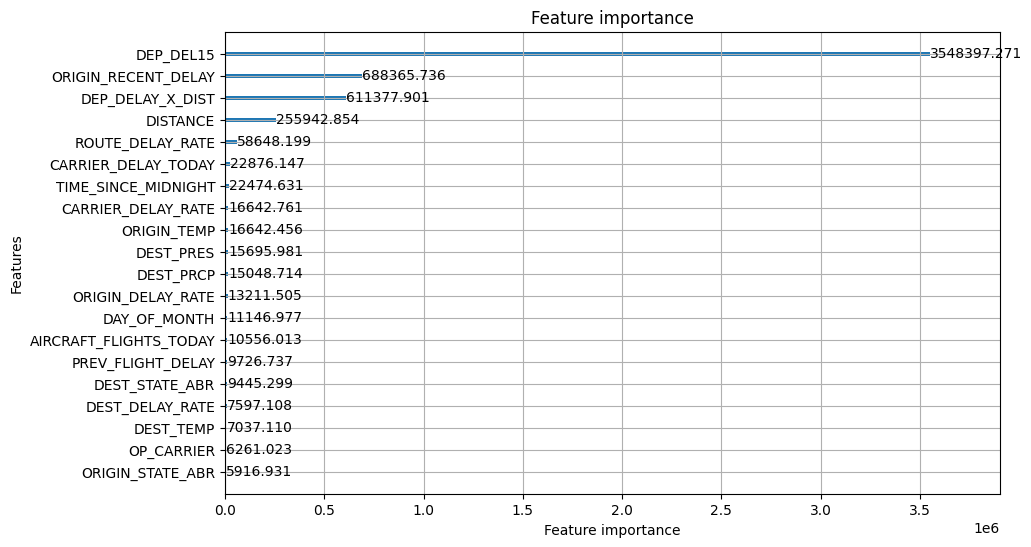

In [44]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score


# --- 5️⃣ Split train/validation ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6️⃣ Prepare LightGBM datasets ---
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# --- 7️⃣ LightGBM parameters ---
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# --- 8️⃣ Train model with early stopping ---
callbacks = [lgb.early_stopping(stopping_rounds=20)]
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=200,
    callbacks=callbacks
)

# --- 9️⃣ Predict & evaluate ---
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

print("AUC:", round(roc_auc_score(y_val, y_pred), 4))
print("Accuracy:", round(accuracy_score(y_val, y_pred_bin), 4))
print("F1 Score:", round(f1_score(y_val, y_pred_bin), 4))

# --- 🔟 Feature importance ---
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.show()

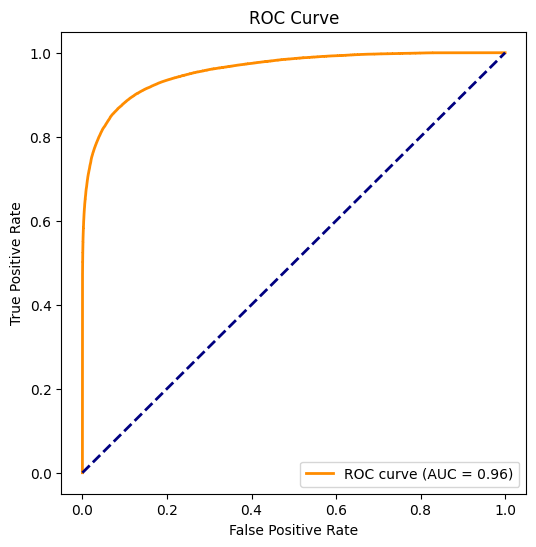

In [45]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Number of numeric features in X: 73

Correlation of numeric features in X with target (ARR_DEL15):
                       corr_with_target
DEP_DEL15                      0.715413
ORIGIN_RECENT_DELAY            0.456319
DEP_DELAY_X_DIST               0.380668
PREV_FLIGHT_DEL15              0.354664
CARRIER_DELAY_TODAY            0.319060
PREV_FLIGHT_DELAY              0.257193
ROUTE_DELAY_RATE               0.176417
ORIGIN_DELAY_RATE              0.112059
HOUR_DELAY_RATE                0.101554
TIME_SINCE_MIDNIGHT            0.093618
DEP_HOUR                       0.093321
DEST_DELAY_RATE                0.091471
ORIGIN_WSPD                    0.090460
HOUR_X_MONTH                   0.086309
CARRIER_DELAY_RATE             0.085556
ARR_HOUR                       0.083781
ORIGIN_TEMP_EXTREME            0.082261
DEST_WSPD                      0.082238
WEATHER_WORSE_AT_DEST          0.082144
DAY_OF_MONTH                  -0.068453


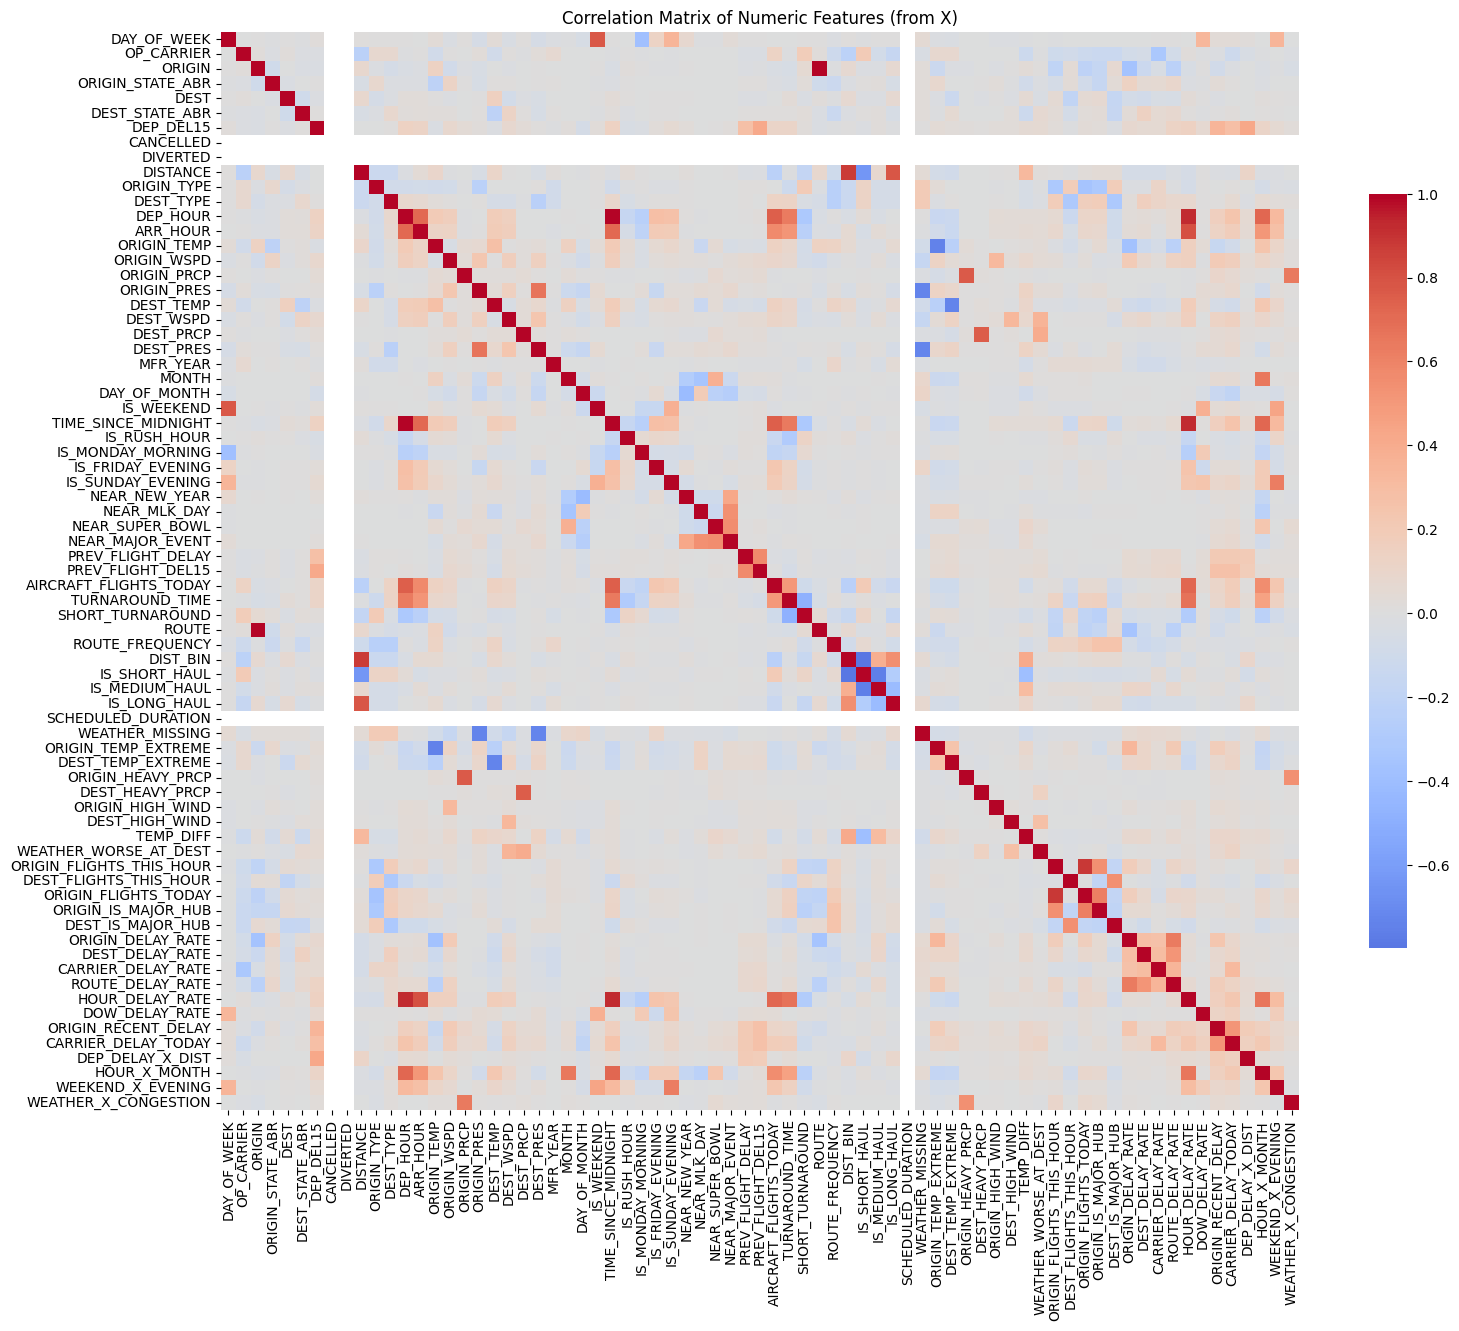


Highly correlated pairs in X (> 0.85 absolute correlation):
ORIGIN ↔ ROUTE: 1.00
DISTANCE ↔ DIST_BIN: 0.88
DEP_HOUR ↔ TIME_SINCE_MIDNIGHT: 1.00
DEP_HOUR ↔ HOUR_DELAY_RATE: 0.92
TIME_SINCE_MIDNIGHT ↔ HOUR_DELAY_RATE: 0.92
ORIGIN_FLIGHTS_THIS_HOUR ↔ ORIGIN_FLIGHTS_TODAY: 0.88


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# Assuming X and y are already prepared from previous steps (numeric features and target)
# If not, re-run the data preparation cells before this one.

# --- 1️⃣ Separate numeric features from the prepared X DataFrame ---
# Select only numeric columns from X
numeric_cols_X = X.select_dtypes(include=np.number).columns.tolist()
print(f"Number of numeric features in X: {len(numeric_cols_X)}")


# --- 2️⃣ Correlation with target (y) ---
# Point-biserial correlation for binary target
target_corr = {}
# Iterate through numeric columns in X
for col in numeric_cols_X:
    # Check if the column has at least two unique values (needed for correlation)
    if X[col].nunique() > 1:
        try:
            corr, _ = pointbiserialr(X[col], y)
            target_corr[col] = corr
        except Exception as e:
             print(f"Could not calculate correlation for {col}: {e}")


target_corr_df = pd.DataFrame.from_dict(target_corr, orient='index', columns=['corr_with_target'])
target_corr_df = target_corr_df.sort_values(by='corr_with_target', key=abs, ascending=False)
print("\nCorrelation of numeric features in X with target (ARR_DEL15):")
print(target_corr_df.head(20))

# --- 3️⃣ Correlation matrix for numeric features in X ---
# Calculate correlation matrix only for numeric columns in X
corr_matrix_X = X[numeric_cols_X].corr()
plt.figure(figsize=(18, 14)) # Increased figure size for better readability
sns.heatmap(corr_matrix_X, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .7}, annot=False) # Set annot=False for fewer labels
plt.title("Correlation Matrix of Numeric Features (from X)")
plt.show()

# --- 4️⃣ Optional: Identify highly correlated features in X ---
threshold = 0.85
high_corr_X = np.where(np.abs(corr_matrix_X) > threshold)
# Filter to get unique pairs (i < j) and exclude self-correlations
high_corr_pairs_X = [(corr_matrix_X.index[i], corr_matrix_X.columns[j], corr_matrix_X.iloc[i,j])
                     for i, j in zip(*high_corr_X) if i != j and i < j]

print("\nHighly correlated pairs in X (> 0.85 absolute correlation):")
if high_corr_pairs_X:
    for a,b,c in high_corr_pairs_X:
        print(f"{a} ↔ {b}: {c:.2f}")
else:
    print("No pairs with absolute correlation > 0.85 found.")

In [49]:
# Drop TIME_SINCE_MIDNIGHT due to high correlation with DEP_HOUR
if 'TIME_SINCE_MIDNIGHT' in X.columns:
    X = X.drop('TIME_SINCE_MIDNIGHT', axis=1)

# Quick check of remaining columns
print(X.columns)

Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_STATE_ABR', 'DEP_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE',
       'ORIGIN_TYPE', 'DEST_TYPE', 'DEP_HOUR', 'ARR_HOUR', 'ORIGIN_TEMP',
       'ORIGIN_WSPD', 'ORIGIN_PRCP', 'ORIGIN_PRES', 'DEST_TEMP', 'DEST_WSPD',
       'DEST_PRCP', 'DEST_PRES', 'MFR_YEAR', 'MONTH', 'DAY_OF_MONTH',
       'IS_WEEKEND', 'IS_RUSH_HOUR', 'IS_EARLY_MORNING', 'IS_EVENING',
       'IS_RED_EYE', 'IS_MONDAY_MORNING', 'IS_FRIDAY_EVENING',
       'IS_SUNDAY_EVENING', 'NEAR_NEW_YEAR', 'NEAR_MLK_DAY', 'NEAR_SUPER_BOWL',
       'NEAR_MAJOR_EVENT', 'PREV_FLIGHT_DELAY', 'PREV_FLIGHT_DEL15',
       'AIRCRAFT_FLIGHTS_TODAY', 'TURNAROUND_TIME', 'SHORT_TURNAROUND',
       'ROUTE', 'ROUTE_FREQUENCY', 'DIST_BIN', 'IS_SHORT_HAUL',
       'IS_MEDIUM_HAUL', 'IS_LONG_HAUL', 'SCHEDULED_DURATION',
       'WEATHER_MISSING', 'ORIGIN_TEMP_EXTREME', 'DEST_TEMP_EXTREME',
       'ORIGIN_HEAVY_PRCP', 'DEST_HEAVY_PRCP', 'ORIGIN_HIGH_WIND',
       'DE

# Hyperparameter tuning



In [51]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.5 MB/s eta 0:00:00


In [55]:
# Optuna + LightGBM time-aware hyperparameter tuning
# Run this in the same notebook where your engineered dataframe (df) exists.
# If df doesn't exist, the script tries to load common CSV file paths.

import os
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping # Import early_stopping callback
import joblib
import warnings
warnings.filterwarnings("ignore")

# ---- 0. Load dataset (try in-memory df first, otherwise load CSV) ----
if 'df' in globals():
    data = df.copy()
else:
    # try common file names
    cand_paths = [
        basePath / "flights_with_feature_engineering.csv"
    ]
    found = False
    for p in cand_paths:
        if os.path.exists(p):
            data = pd.read_csv(p, parse_dates=['FL_DATE'])
            found = True
            print("Loaded", p)
            break
    if not found:
        raise FileNotFoundError("No dataframe `df` in memory and no CSV found at expected paths.")

# ---- 1. Basic preprocessing for tuning ----
# Ensure FL_DATE exists and is datetime
if 'FL_DATE' in data.columns:
    data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])
else:
    raise KeyError("FL_DATE column missing - needed for time-aware CV.")

# Target
if 'ARR_DEL15' not in data.columns:
    raise KeyError("ARR_DEL15 target column not found in dataframe.")

# Drop rows with missing target
data = data.dropna(subset=['ARR_DEL15']).reset_index(drop=True)
y = data['ARR_DEL15'].astype(int)

# Feature selection: exclude leakage & meta columns
exclude = {
    'ARR_DEL15', 'FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'OP_CARRIER_FL_NUM', 'TAIL_NUM'
}
features = [c for c in data.columns if c not in exclude]

X = data[features].copy()

# Auto-detect categorical columns for LightGBM (keep names)
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() < 100]

# Fill NA for numeric features (LightGBM handles NaN but our sklearn wrapper prefers no object NAs)
for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].astype(str).fillna("MISSING")
    else:
        # numeric
        X[col] = X[col].astype(float)  # ensure floats
        # keep NaNs (LGBM can handle), but to avoid sklearn fit issues fill with median
        X[col] = X[col].fillna(X[col].median())


# Convert categorical cols to category dtype for LGBM
for c in cat_cols:
    X[c] = X[c].astype('category')


# ---- 2. Create time-aware splits ----
# We'll sort by FL_DATE and use TimeSeriesSplit
order = np.argsort(data['FL_DATE'].values)
X_sorted = X.iloc[order].reset_index(drop=True)
y_sorted = y.iloc[order].reset_index(drop=True)
dates_sorted = data['FL_DATE'].iloc[order].reset_index(drop=True)

n_splits = 3  # time folds
tscv = TimeSeriesSplit(n_splits=n_splits)

# ---- 3. Optuna objective ----
def objective(trial):
    # hyperparameter search space
    param = {
        'n_estimators': 1000,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'verbosity': -1,
        'n_jobs': 4,
        # handle class imbalance with scale_pos_weight if desired (optional)
        # 'scale_pos_weight': (y_sorted == 0).sum() / (y_sorted == 1).sum()
    }

    aucs = []
    # perform time-series CV
    for train_idx, val_idx in tscv.split(X_sorted):
        X_train, X_valid = X_sorted.iloc[train_idx], X_sorted.iloc[val_idx]
        y_train, y_valid = y_sorted.iloc[train_idx], y_sorted.iloc[val_idx]

        model = LGBMClassifier(**param, random_state=42)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='auc',
            callbacks=[early_stopping(20, verbose=False)], # Use callbacks parameter
            # verbose=False, # verbose is part of callbacks now
            categorical_feature=cat_cols
        )
        y_pred = model.predict_proba(X_valid, num_iteration=model.best_iteration_)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        aucs.append(auc)

    # return mean AUC across folds (maximize)
    return np.mean(aucs)

# ---- 4. Run Optuna study ----
n_trials = 20  # change to 100/200 if you have time/resources
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)

print("Best trial:")
print("  AUC:", study.best_value)
print("  Params:")
for k,v in study.best_params.items():
    print(f"    {k}: {v}")

# ---- 5. Train final model on full training period (all data except last temporal fold) ----
# Common approach: train on everything and save final model (or retrain on train+val up to last date)
best_params = study.best_params
final_params = {
    'n_estimators': 1000,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': best_params['learning_rate'],
    'num_leaves': best_params['num_leaves'],
    'max_depth': best_params['max_depth'],
    'min_child_samples': best_params['min_child_samples'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'verbosity': -1,
    'n_jobs': 4,
}

# Train final on all data (or you can hold out a final temporal test set)
final_model = LGBMClassifier(**final_params, random_state=42)
# Use callbacks for early stopping during final training if desired
# final_model.fit(X_sorted, y_sorted, eval_metric='auc', callbacks=[early_stopping(100, verbose=True)])
# Or train for a fixed number of estimators determined by Optuna's best iteration from CV
# You would need to store best_iteration_ from the CV loop, e.g., model.best_iteration_
# For simplicity here, let's train for a fixed number or use a simple validation set if needed
final_model.fit(X_sorted, y_sorted, eval_metric='auc', callbacks=[early_stopping(100, verbose=True)])


# Save model
joblib.dump(final_model, basePath / "lgbm_optuna_best.pkl")
print("Final model saved to lgbm_optuna_best.pkl")

[I 2025-11-04 11:17:11,447] A new study created in memory with name: no-name-0a17acfb-de3b-44da-a438-384eb59c0a3a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-04 11:23:16,645] Trial 0 finished with value: 0.9548208371187833 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.49359671220172163, 'reg_alpha': 0.11616722433639892, 'reg_lambda': 1.7323522915498704}. Best is trial 0 with value: 0.9548208371187833.
[I 2025-11-04 11:27:09,209] Trial 1 finished with value: 0.9537892133706376 and parameters: {'learning_rate': 0.06054365855469246, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 98, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.5274034664069657, 'reg_alpha': 0.36364993441420124, 'reg_lambda': 0.36680901970686763}. Best is trial 0 with value: 0.9548208371187833.
[I 2025-11-04 11:34:34,412] Trial 2 finished with value: 0.954819478935415 and parameters: {'learning_rate': 0.024878734419814436, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 36, 'subsample': 0.8059264473611898, 'colsample_by

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [58]:
# Train final on all data (or you can hold out a final temporal test set)
final_model = LGBMClassifier(**final_params, random_state=42)
# Use callbacks for early stopping during final training if desired
# final_model.fit(X_sorted, y_sorted, eval_metric='auc', callbacks=[early_stopping(100, verbose=True)])
# Or train for a fixed number of estimators determined by Optuna's best iteration from CV
# You would need to store best_iteration_ from the CV loop, e.g., model.best_iteration_
# For simplicity here, let's train for a fixed number or use a simple validation set if needed
# final_model.fit(X_sorted, y_sorted, eval_metric='auc', callbacks=[early_stopping(20, verbose=True)])
final_model.fit(X_sorted, y_sorted) #, eval_metric='auc', callbacks=[early_stopping(20, verbose=True)])


# Save model
joblib.dump(final_model, basePath / "lgbm_optuna_best.pkl")
print("Final model saved to lgbm_optuna_best.pkl")

Final model saved to lgbm_optuna_best.pkl


Train shape: (814996, 83) Test shape: (203749, 83)

Top 20 features by gain:
                     feature          gain  split
0                  DEP_DEL15  4.610822e+06    407
1           DEP_DELAY_X_DIST  3.059545e+06   5922
2        ORIGIN_RECENT_DELAY  1.352051e+06   3147
3                      ROUTE  5.568093e+05   9074
4                   DISTANCE  3.082523e+05   2108
5                       DEST  2.399022e+05   6413
6          PREV_FLIGHT_DELAY  2.290076e+05   3018
7                     ORIGIN  2.201049e+05   5513
8               DAY_OF_MONTH  1.922683e+05   6574
9                   DIST_BIN  1.689221e+05    320
10       CARRIER_DELAY_TODAY  1.577556e+05   3379
11           TURNAROUND_TIME  1.134458e+05   2045
12          ROUTE_DELAY_RATE  9.992130e+04   1203
13    DEST_FLIGHTS_THIS_HOUR  8.095149e+04   4955
14  ORIGIN_FLIGHTS_THIS_HOUR  8.037862e+04   5054
15              HOUR_X_MONTH  7.461527e+04   4824
16          ORIGIN_STATE_ABR  7.430351e+04   2186
17         PREV_FLIGHT_

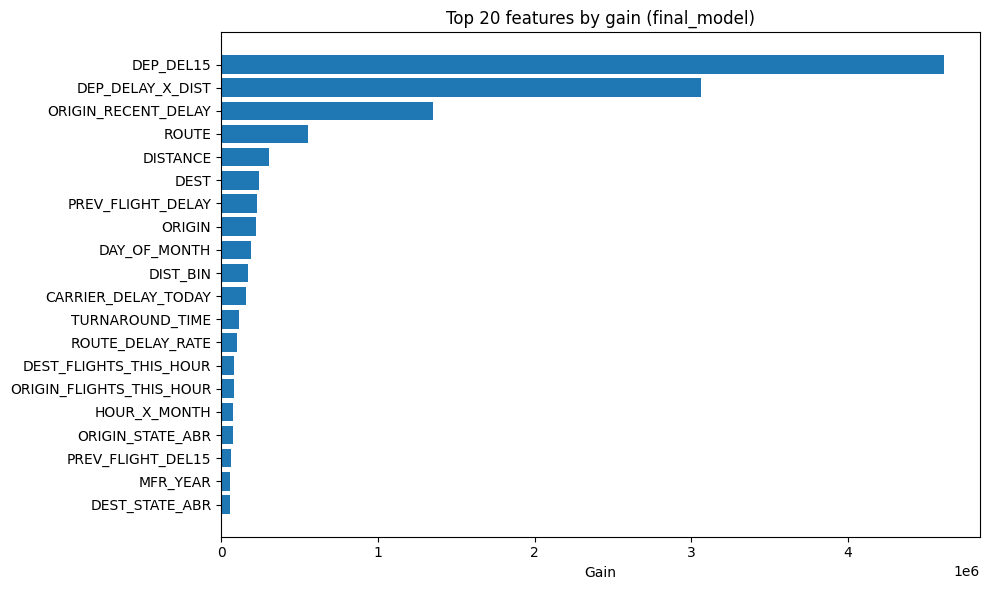


Computing permutation importance (this may take a minute)...


In [ ]:
# ---------- Feature importance, permutation importance, SHAP, and top-k retrain ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
import joblib
import shap
import os

# --- 0. Sanity: make sure final_model exists ---
try:
    final_model  # from your previous cell
except NameError:
    raise RuntimeError("final_model not found. Make sure to run the training cell first and have final_model in scope.")

# --- 1. Create temporal holdout (last 20%) ---
holdout_frac = 0.2
n = len(dates_sorted)
holdout_start_idx = int((1 - holdout_frac) * n)

X_train_final = X_sorted.iloc[:holdout_start_idx].reset_index(drop=True)
y_train_final = y_sorted.iloc[:holdout_start_idx].reset_index(drop=True)
X_test_final  = X_sorted.iloc[holdout_start_idx:].reset_index(drop=True)
y_test_final  = y_sorted.iloc[holdout_start_idx:].reset_index(drop=True)

print("Train shape:", X_train_final.shape, "Test shape:", X_test_final.shape)

# Ensure categorical dtypes are preserved in test/train
for c in cat_cols:
    if c in X_train_final.columns:
        X_train_final[c] = X_train_final[c].astype('category')
        X_test_final[c]  = X_test_final[c].astype('category')

# ---------- A. LightGBM built-in feature importance ----------
fi = pd.DataFrame({
    'feature': final_model.booster_.feature_name(),
    'gain': final_model.booster_.feature_importance(importance_type='gain'),
    'split': final_model.booster_.feature_importance(importance_type='split')
}).sort_values('gain', ascending=False).reset_index(drop=True)

print("\nTop 20 features by gain:")
print(fi.head(20))
fi.to_csv("feature_importance_gain.csv", index=False)

plt.figure(figsize=(10,6))
plt.barh(fi['feature'].head(20)[::-1], fi['gain'].head(20)[::-1])
plt.title("Top 20 features by gain (final_model)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

# ---------- B. Permutation importance (AUC drop) ----------
print("\nComputing permutation importance (this may take a minute)...")
pi = permutation_importance(final_model, X_test_final, y_test_final,
                            n_repeats=10, scoring='roc_auc', n_jobs=4, random_state=42)

pi_df = pd.DataFrame({
    'feature': X_test_final.columns,
    'perm_mean': pi.importances_mean,
    'perm_std': pi.importances_std
}).sort_values('perm_mean', ascending=False).reset_index(drop=True)

print("\nTop 20 permutation importances (AUC drop):")
print(pi_df.head(20))
pi_df.to_csv("permutation_importance.csv", index=False)

plt.figure(figsize=(10,6))
plt.barh(pi_df['feature'].head(20)[::-1], pi_df['perm_mean'].head(20)[::-1])
plt.title("Top 20 permutation importances (AUC drop)")
plt.xlabel("Mean AUC drop")
plt.tight_layout()
plt.show()

# ---------- C. SHAP analysis ----------
print("\nRunning SHAP (sampling if large)...")
shap.initjs()
explainer = shap.TreeExplainer(final_model)

# choose sample (max 20000 rows for speed)
max_shap = 20000
X_shap = X_test_final.sample(n=min(max_shap, len(X_test_final)), random_state=42)
# convert categorical columns to numeric if shap needs it (TreeExplainer handles categorical but ensure types OK)
for c in cat_cols:
    if c in X_shap.columns:
        X_shap[c] = X_shap[c].astype('category')

# compute shap values (for binary classifier shap may return list or array)
shap_values = explainer.shap_values(X_shap)
# shap_values could be [neg_class, pos_class] or an array; pick positive class if list
if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values

# global summary plot
print("SHAP summary plot (may open a new window)...")
shap.summary_plot(shap_vals, X_shap, plot_type="dot", max_display=20, show=True)

# Dependence plots for top features by gain (top 6)
top_features = fi['feature'].head(6).tolist()
print("Top features for SHAP dependence plots:", top_features)
for f in top_features:
    if f in X_shap.columns:
        print("Dependence plot for", f)
        shap.dependence_plot(f, shap_vals, X_shap, show=True, interaction_index=None)

# Save a small SHAP table for reporting (mean absolute shap)
shap_abs_mean = np.abs(shap_vals).mean(axis=0)
shap_df = pd.DataFrame({'feature': X_shap.columns, 'shap_mean_abs': shap_abs_mean}).sort_values('shap_mean_abs', ascending=False)
shap_df.to_csv("shap_mean_abs.csv", index=False)
print("Saved shap_mean_abs.csv")

# ---------- D. Quick retrain with top-k features ----------
from sklearn.model_selection import train_test_split
def retrain_with_topk(k=20):
    topk = fi['feature'].head(k).tolist()
    print(f"\nRetraining with top-{k} features (k={k}):", topk)
    # Prepare training/test splits (use temporal splits defined above)
    X_tr = X_train_final[topk]
    X_te = X_test_final[topk]
    # preserve categorical dtypes
    for c in topk:
        if c in cat_cols:
            X_tr[c] = X_tr[c].astype('category')
            X_te[c] = X_te[c].astype('category')
    # train fresh LGBM using same final params as your final_model
    # extract params from final_model if available, otherwise use reasonable defaults
    try:
        base_params = final_model.booster_.get_params()
    except:
        base_params = {
            'n_estimators': 1000, 'learning_rate': 0.03, 'num_leaves': 64, 'random_state':42
        }
    model_k = LGBMClassifier(**{k:v for k,v in base_params.items() if k in ['n_estimators','learning_rate','num_leaves','max_depth','min_child_samples','subsample','colsample_bytree','reg_alpha','reg_lambda','n_jobs','random_state']})
    model_k.fit(X_tr, y_train_final,
                eval_set=[(X_te, y_test_final)],
                eval_metric='auc',
                early_stopping_rounds=100,
                verbose=False,
                categorical_feature=[c for c in topk if c in cat_cols])
    y_pred = model_k.predict_proba(X_te, num_iteration=model_k.best_iteration_)[:,1]
    auc = roc_auc_score(y_test_final, y_pred)
    pr_auc = average_precision_score(y_test_final, y_pred)
    print(f"Top-{k} AUC: {auc:.4f}  PR-AUC: {pr_auc:.4f}")
    return auc, pr_auc

results = {}
for k in [10, 20, 30, 50]:
    results[k] = retrain_with_topk(k)

print("\nTop-k retrain results (AUC, PR-AUC):")
for k,(auc,pr) in results.items():
    print(f" top-{k}: AUC={auc:.4f}, PR-AUC={pr:.4f}")

# ---------- E. Save final artifacts ----------
os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(final_model, "model_artifacts/final_model.pkl")
fi.to_csv("model_artifacts/feature_importance_gain.csv", index=False)
pi_df.to_csv("model_artifacts/permutation_importance.csv", index=False)
shap_df.to_csv("model_artifacts/shap_mean_abs.csv", index=False)
print("Saved artifacts to model_artifacts/")

print("\nDone — feature importance, permutation importance, SHAP, and top-k retrain complete.")


# Limitations

- **Class imbalance**
  - Class imbalance here is moderate (~20% positives).
  - **Steps:**
    - (1) try scale_pos_weight or LightGBM is_unbalance
    - (2) evaluate class-weighted loss vs. simple thresholding
    - (3) consider resampling only in training (SMOTE/undersampling) if needed
    - (4) optimize decision threshold for business metric (precision@k or recall target)
  - **Benefits:**
    - improved recall/precision tradeoff for minority class
    - better calibrated probabilities where you need to prioritize true alerts while controlling operator load